# testing how to evaluate the joint models

In [1]:
!nvidia-smi

Thu Mar 27 22:34:06 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:17:00.0 Off |                    0 |
| N/A   30C    P0              43W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
#can do something similar to the evals utils for enformer, just manually define it

from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.encoders import JointCNN
from src.tasks.decoders import JointMaskingDecoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
from src.dataloaders.datasets.general_dataset import GeneralDataset
import yaml
from omegaconf import OmegaConf
import os
import matplotlib.pyplot as plt

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")

In [3]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/17-11-44-581934/checkpoints/last.ckpt'
model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
cfg = OmegaConf.create(cfg)
cfg = OmegaConf.to_container(cfg, resolve=True)
state_dict = torch.load(ckpt_path, map_location='cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
split = 'val'

In [4]:
import inspect
dataset_args = cfg['dataset']
sig = inspect.signature(GeneralDataset.__init__)
sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
to_remove = []
for k, v in dataset_args.items():
    if k not in sig:
        # del dataset_args[k]
        to_remove.append(k)
for k in to_remove:
    del dataset_args[k]
dataset_args['split'] = split
dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
# self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
dataset = GeneralDataset(**dataset_args)
print(len(dataset))

2213


In [5]:
dataset_args

{'data_path': '/data1/lesliec/sarthak/data/DK_zarr/zarr_arrays/cell_type_arrays/GM12878_DNase.npz',
 'length': 524288,
 'shift_sequences': 1000,
 'load_in': False,
 'rc_aug': False,
 'mlm': 0.25,
 'acc_mlm': 0.25,
 'acc_type': 'continuous',
 'acc_mask_size': 500,
 'weight_peaks': False,
 'split': 'val'}

In [6]:
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
encoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "encoder" in key:
        encoder_state_dict[key[10:]] = model_state_dict.pop(key)

cfg['model']['config'].pop('_target_')
# cfg['model']['config']['complement_map'] = dataset.tokenizer.complement_map
caduceus_cfg = CaduceusConfig(**cfg['model']['config'])

backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
backbone.load_state_dict(model_state_dict, strict=True)

<All keys matched successfully>

In [7]:
backbone

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): Transpose()
      )
      (layers): ModuleList(
        (0-15): 16 x Block(
          (norm): RMSNorm()
          (mixer): BiMambaWrapper(
            (mamba_fwd): Mamba(
              (in_proj): Linear(in_features=256, out_features=1024, bias=False)
              (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
              (act): SiLU()
              (x_proj): Linear(in_features=512, out_features=48, bias=False)
              (dt_proj): Linear(in_features=16, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=256, bias=False)
            )
            (mamba_rev): Mamba(
              (in_proj): Linear(in_features=256, out_features=1024, bias=False)
              (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
           

In [8]:
del cfg['decoder']['_name_']
cfg['decoder']['d_model'] = cfg['model']['config']['d_model']
decoder = JointMaskingDecoder(**cfg['decoder']) #could do with instantiating, but that is rather complex
decoder.load_state_dict(decoder_state_dict, strict=True)
decoder

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1


JointMaskingDecoder(
  (decoder1): Linear(in_features=256, out_features=5, bias=True)
  (decoder2): Linear(in_features=256, out_features=1, bias=True)
)

In [9]:
cfg['encoder']

{'_name_': 'jointcnn',
 'joint': False,
 'combine': True,
 'acc_type': 'continuous'}

In [10]:
del cfg['encoder']['_name_']
cfg['encoder']['d_model'] = cfg['model']['config']['d_model']
encoder = JointCNN(**cfg['encoder'])
encoder.load_state_dict(encoder_state_dict, strict=True)
encoder

JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


JointCNN(
  (conv1): Sequential(
    (0): Conv1d(6, 128, kernel_size=(15,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(2, 128, kernel_size=(15,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (out): Linear(in_features=256, out_features=256, bias=True)
)

In [11]:
device = torch.device('cuda:0')
encoder = encoder.to(device).eval()
decoder = decoder.to(device).eval()
backbone = backbone.to(device).eval()

In [18]:
#let's see an example output

(seq,acc),(seq_unmask,acc_unmask) = dataset[0]
x = seq.unsqueeze(0).to(device)
y = acc.unsqueeze(0).to(device)
print(x.shape, y.shape)

torch.Size([1, 6, 524288]) torch.Size([1, 2, 524288])


In [19]:
with torch.no_grad():
    x = encoder(x,y)
    print(x.shape)
    x,_ = backbone(x)
    print(x.shape)
    x = decoder(x)
    print(x[0].shape, x[1].shape)

torch.Size([1, 256, 524288])
torch.Size([1, 524288, 256])
torch.Size([1, 524288, 5]) torch.Size([1, 524288, 1])


In [21]:
#for the first 100 points, let's plot the relative values for the 5 classes
acc_unmask.shape

torch.Size([524288, 2])

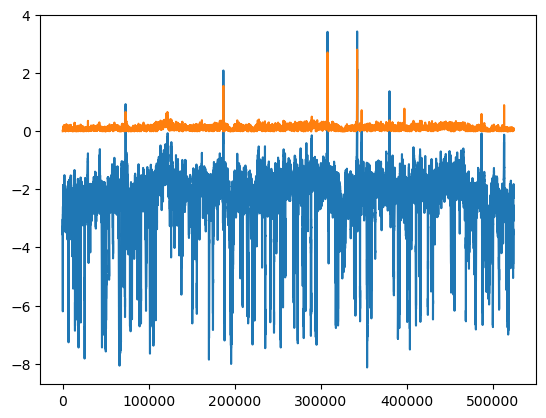

In [ ]:
plt.plot(x[1][0,:,0].cpu().numpy())
plt.plot(acc_unmask[:,0].cpu().numpy())



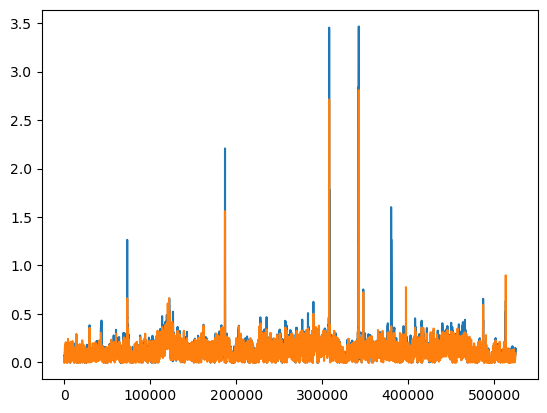

In [ ]:
#wait we almost forgot the softplus!!
acc = torch.nn.functional.softplus(x[1])
plt.plot(acc[0,:,0].cpu().numpy())
plt.plot(acc_unmask[:,0].cpu().numpy())

#most of it is good, because remember all it does is plot where the values were masked, so have to plot the mask too!

#this is stuf we'll have to build eval tools for!

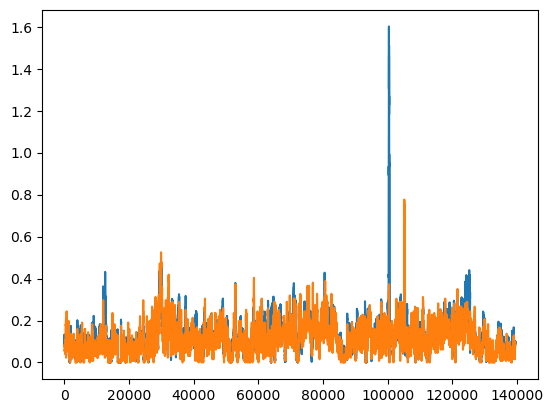

In [ ]:
mask = acc_unmask[:,1] == 1
plt.plot(acc[0,mask,0].cpu().numpy())
plt.plot(acc_unmask[mask,0].cpu().numpy())

#misses the peak for example, this model also has barely been trained so it's to be expected!

In [1]:
#and we can also do sequence, but that's another thing! and it will be quite hard, let's make an evals class!
#we need to define a way to do it for specific sequences, so like it gets the data with no mask then masks it itself. can just get the mask and unmask sequences directly and then does manual masking of regions

#first let's test the class as a whole
#we'll also test it with a more trained model
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

from evals.evals_utils_joint import Evals
evals = Evals(ckpt_path,device=1)

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [2]:
evals.encoder

JointCNN(
  (conv1): Sequential(
    (0): Conv1d(6, 128, kernel_size=(15,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(2, 128, kernel_size=(15,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (out): Linear(in_features=256, out_features=256, bias=True)
)

In [3]:
out = evals(0)
out[0].shape, out[1].shape, out[2].shape, out[3].shape

(torch.Size([1, 524288, 5]),
 torch.Size([1, 524288, 1]),
 torch.Size([524288, 6]),
 torch.Size([524288, 2]))

In [4]:
#and let's run it unmasked

out = evals.run_unmask(0)
out[0].shape, out[1].shape, out[2].shape, out[3].shape

(torch.Size([1, 524288, 5]),
 torch.Size([1, 524288, 1]),
 torch.Size([524288, 6]),
 torch.Size([524288, 2]))

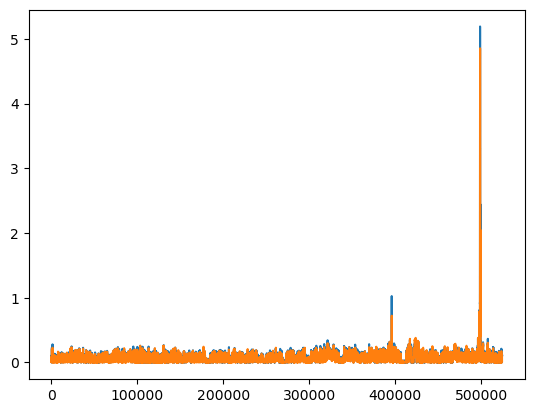

In [5]:
#let's plot it to see if this makes sense
import matplotlib.pyplot as plt
plt.plot(out[1][0,:,0].cpu().numpy(), label='unmasked predictions')
plt.plot(out[3][:,0].cpu().numpy(), label='proper label')

In [ ]:
#let's find the pearson correlation between them
from scipy.stats import pearsonr
pearsonr(out[1][0,:,0].cpu().numpy(), out[3][:,0].cpu().numpy()) #exxtremely high and it's quite logical, model does usuallyy predict what it should
#key idea tho is that it will underpredict peaks it seems, let's look at another exxample

PearsonRResult(statistic=0.9861822583608971, pvalue=0.0)

PearsonRResult(statistic=0.9822597457315524, pvalue=0.0)


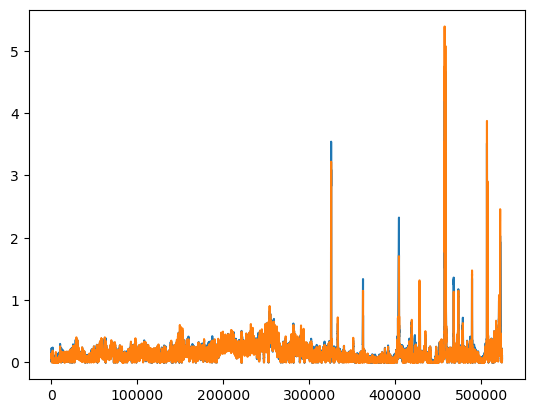

In [7]:
out = evals.run_unmask(15)
plt.plot(out[1][0,:,0].cpu().numpy(), label='unmasked predictions')
plt.plot(out[3][:,0].cpu().numpy(), label='proper label')
print(pearsonr(out[1][0,:,0].cpu().numpy(), out[3][:,0].cpu().numpy())) #not as good but still pretty good!

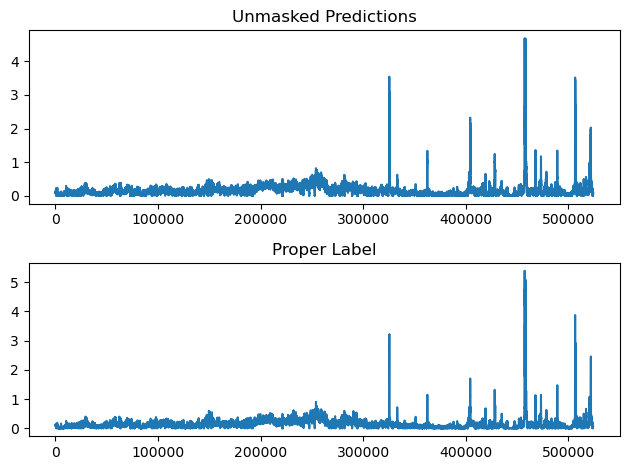

In [8]:
#should plot these tracks on separate plots
plt.subplot(2,1,1)
plt.plot(out[1][0,:,0].cpu().numpy(), label='unmasked predictions')
plt.title('Unmasked Predictions')
plt.subplot(2,1,2)
plt.plot(out[3][:,0].cpu().numpy(), label='proper label')
plt.title('Proper Label')
plt.tight_layout()

In [9]:
#clearlyh these are very similar and near identicsal. The thing that's lacking is seeing what the mdoel predicts if we set part of it to 0

#let's find the area around the peak
max_index = out[3][:,0].argmax()
print(max_index)

tensor(457514)


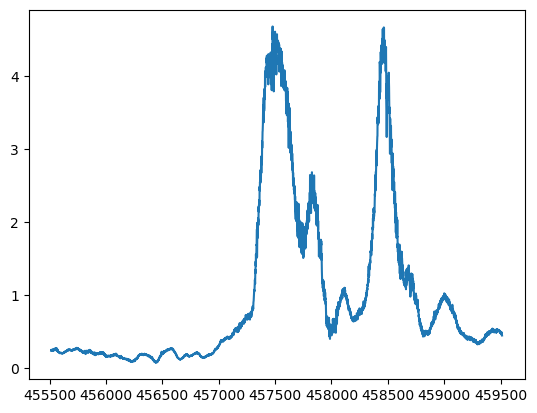

In [14]:
#plot around the max index
import numpy as np
x_vals = np.arange(max_index - 2000, max_index + 2000)
y_vals = out[1][0, max_index - 2000 : max_index + 2000, 0].cpu().numpy()

plt.plot(x_vals, y_vals, label='unmasked predictions')


In [16]:
#ok now we need to mask that region and see what it predicts, first let's set it to neare 0 but just noise or repeat the noise it saw before
out[3].shape

torch.Size([524288, 2])

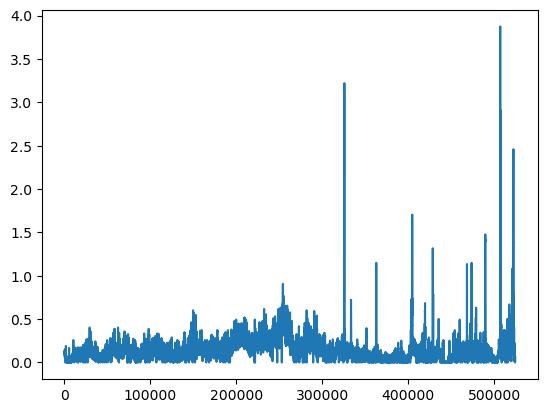

In [22]:
acc = out[3].clone()
acc[max_index - 2000 : max_index + 2000, 0] = acc[max_index - 8000 : max_index - 4000, 0] #set to a random value
plt.plot(acc[:,0].cpu().numpy(), label='masked label')

In [24]:
print(out[0].shape, acc.transpose(1,0).shape)

torch.Size([1, 524288, 5]) torch.Size([2, 524288])


In [25]:
print(out[0].squeeze(0).transpose(1,0).shape, acc.transpose(1,0).shape)

torch.Size([5, 524288]) torch.Size([2, 524288])


In [27]:
#now put this into the model and see what's up
modified_data = (out[0].squeeze(0).transpose(1,0), acc.transpose(1,0), out[2], out[3]) #just modify the acc, keep everything else the same
out2 = evals(data = modified_data)

RuntimeError: Given groups=1, weight of size [128, 6, 15], expected input[1, 5, 524288] to have 6 channels, but got 5 channels instead

In [35]:
#that's a bad way to do it let's get the data fresh again!
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15] #get the original data
print(seq.shape, acc.shape, seq_unmask.shape, acc_unmask.shape)
acc = acc_unmask.clone()
acc[max_index - 2000 : max_index + 2000, 0] = acc[max_index - 8000 : max_index - 4000, 0] #set to a random value
acc = acc.transpose(1,0)
print(seq.shape, acc.shape, seq_unmask.shape, acc_unmask.shape)

torch.Size([6, 524288]) torch.Size([2, 524288]) torch.Size([524288, 6]) torch.Size([524288, 2])
torch.Size([6, 524288]) torch.Size([2, 524288]) torch.Size([524288, 6]) torch.Size([524288, 2])


In [32]:
#let's now define nothing as masked... 
seq[-1] = 0
acc[-1] = 0
print(seq.sum(1))
print(acc.sum(1))

tensor([115572.,  99180.,  97129., 107454.,      0.,      0.])
tensor([77192.2734,     0.0000])


In [34]:
print(seq.shape, acc.shape)

torch.Size([6, 524288]) torch.Size([2, 524288])


In [33]:
#and predict
modified_data = (seq, acc, seq_unmask, acc_unmask) #just modify the acc, keep everything else the same
out2 = evals(data = modified_data)
print(out2[0].shape, out2[1].shape, out2[2].shape, out2[3].shape)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [39]:
seq.dim()

2

In [1]:
#made some changes, let's restart really quickly!

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
evals = Evals(ckpt_path,device=1)

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [4]:
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15] #get the original data
max_index = acc_unmask[:,0].argmax()
print(max_index)

tensor(457514)


In [29]:
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15] #get the original data
print(seq.shape, acc.shape, seq_unmask.shape, acc_unmask.shape)
acc = acc_unmask.clone()
acc[max_index - 2000 : max_index + 2000, 0] = acc[max_index - 8000 : max_index - 4000, 0] #set to a random value
acc = acc.transpose(1,0)

#and zzero out the seq and acc masks
seq[-1] = 0
acc[-1] = 0

print(seq.shape, acc.shape, seq_unmask.shape, acc_unmask.shape)

torch.Size([6, 524288]) torch.Size([2, 524288]) torch.Size([524288, 6]) torch.Size([524288, 2])
torch.Size([6, 524288]) torch.Size([2, 524288]) torch.Size([524288, 6]) torch.Size([524288, 2])


In [30]:
modified_data = (seq, acc, seq_unmask, acc_unmask) #just modify the acc, keep everything else the same
out2 = evals(data = modified_data)
print(out2[0].shape, out2[1].shape, out2[2].shape, out2[3].shape)

torch.Size([1, 524288, 5]) torch.Size([1, 524288, 1]) torch.Size([524288, 6]) torch.Size([524288, 2])


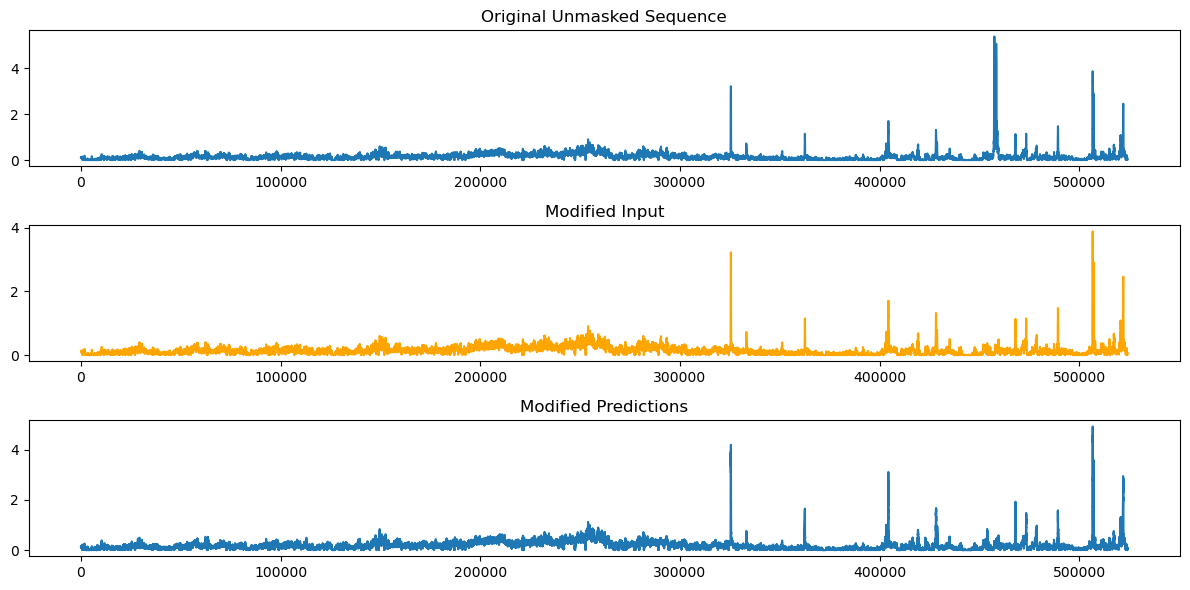

In [31]:
#and now we plot it again
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(acc_unmask[:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(acc[0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out2[1][0, :, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')


plt.tight_layout()

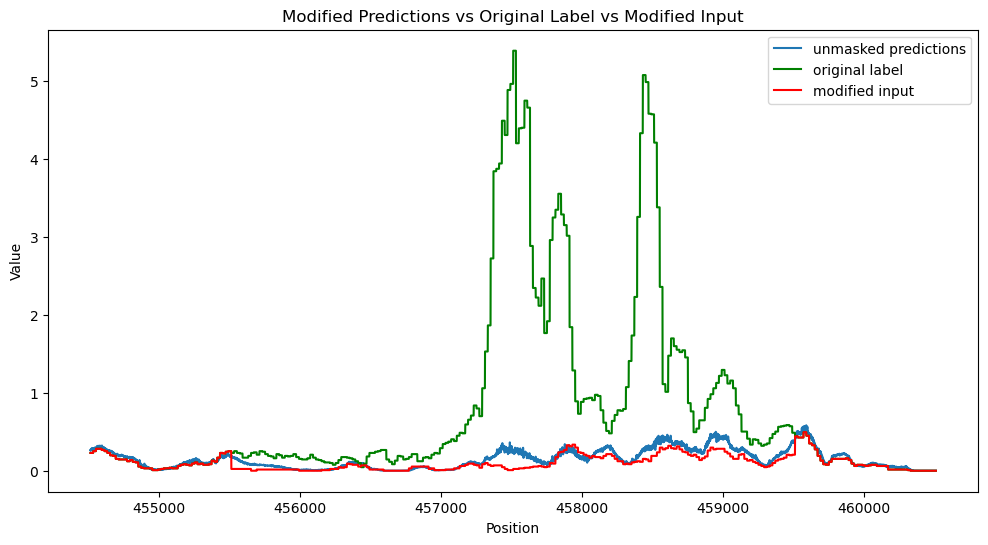

In [32]:
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out2[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out2[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = acc[0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

In [14]:
#what if we mask it then tell it to ppredict? clearly trusts the input a lot which is fair
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15]
acc = acc_unmask.clone()
acc[max_index - 2000 : max_index + 2000, 0] = acc[max_index - 8000 : max_index - 4000, 0] #set to a random value
acc = acc.transpose(1,0)

seq[-1] = 0
acc[-1] = 0

acc[-1,max_index - 2000 : max_index + 2000] = 1 #mask it

print(seq.shape, acc.shape, seq_unmask.shape, acc_unmask.shape)

torch.Size([6, 524288]) torch.Size([2, 524288]) torch.Size([524288, 6]) torch.Size([524288, 2])


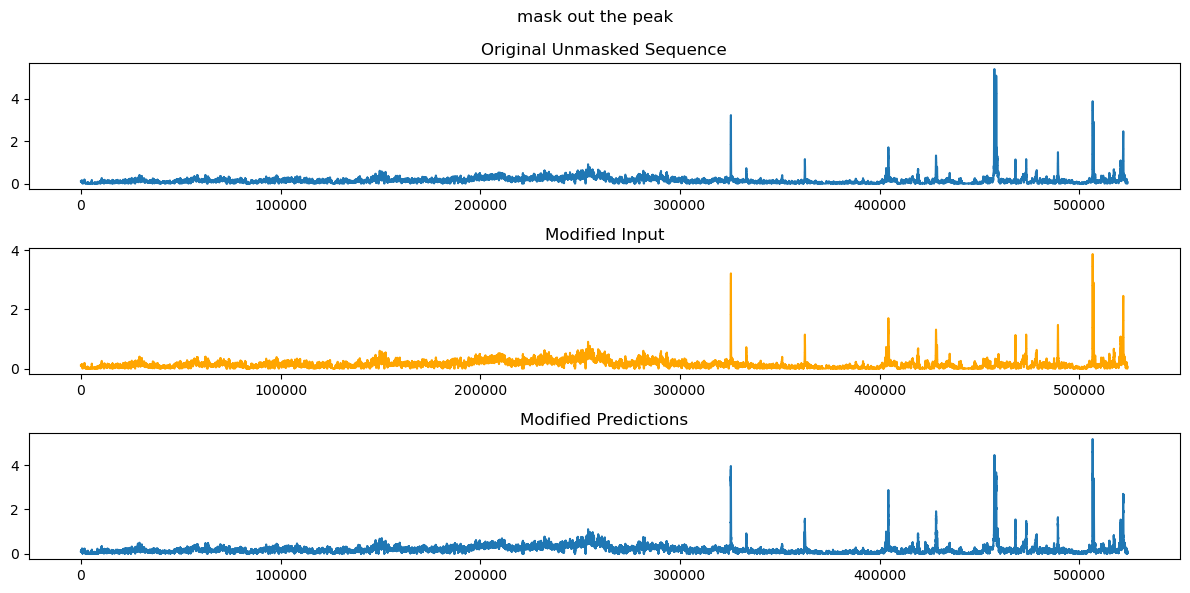

In [16]:
modified_data = (seq, acc, seq_unmask, acc_unmask) #just modify the acc, keep everything else the same
out2 = evals(data = modified_data)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(acc_unmask[:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(acc[0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out2[1][0, :, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak')


plt.tight_layout()

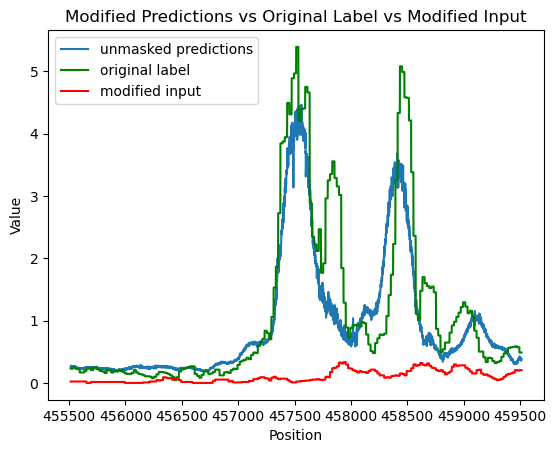

In [19]:
#let's plot just the region
x_vals = np.arange(max_index - 2000, max_index + 2000)
y_vals = out2[1][0, max_index - 2000 : max_index + 2000, 0].cpu().numpy()

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out2[3][:, 0].cpu().numpy()[max_index - 2000 : max_index + 2000]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = acc[0, max_index - 2000 : max_index + 2000].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

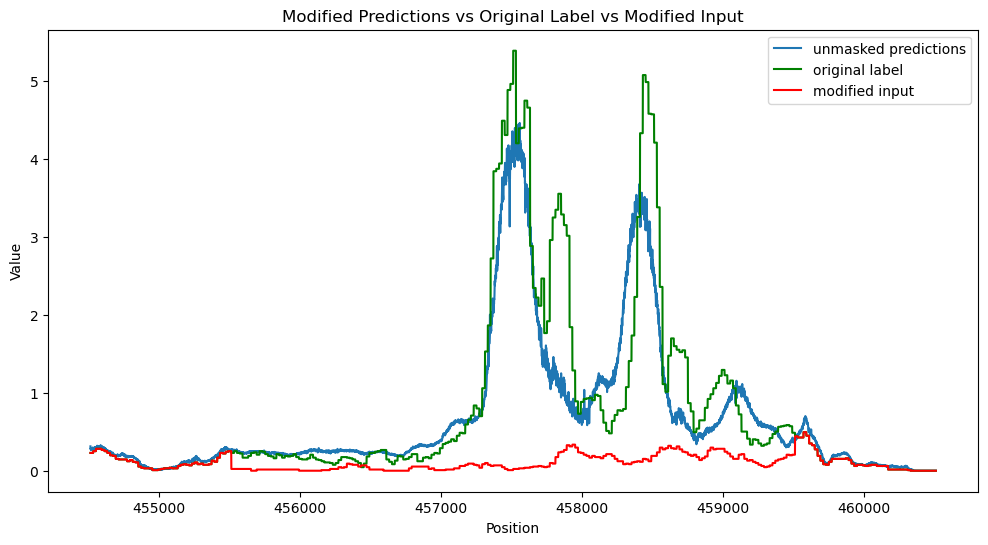

In [25]:
#let's plot just the region

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out2[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out2[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = acc[0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

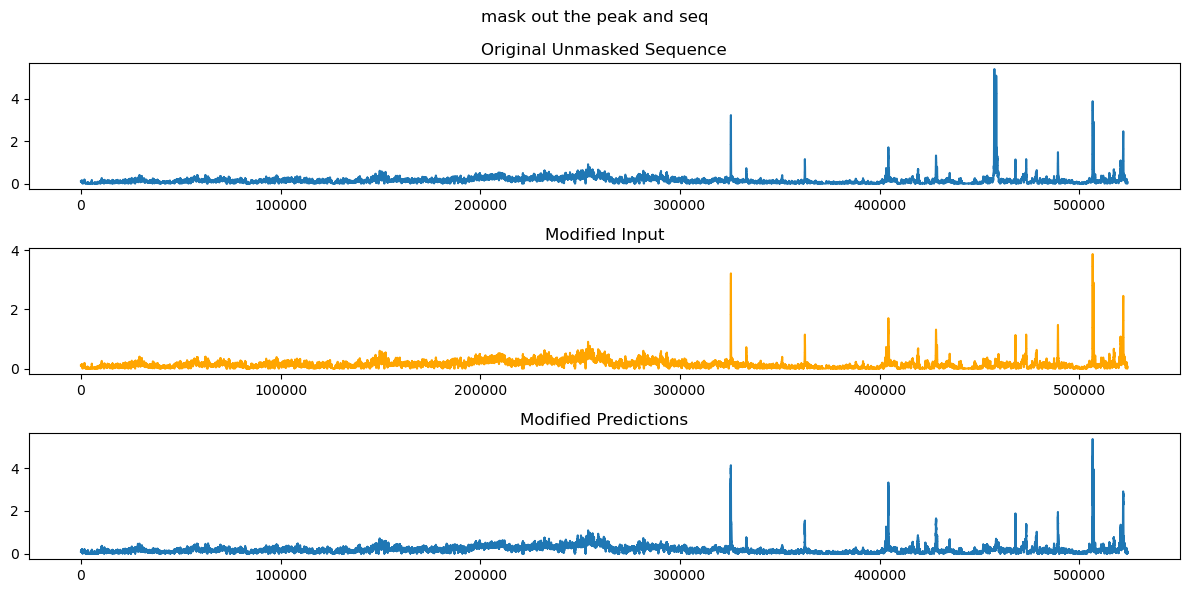

In [ ]:
#what if we mask the sequence in that region?

(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15]
acc = acc_unmask.clone()
acc[max_index - 2000 : max_index + 2000, 0] = acc[max_index - 8000 : max_index - 4000, 0] #set to a random value
acc = acc.transpose(1,0)

seq[-1] = 0
acc[-1] = 0

acc[-1,max_index - 2000 : max_index + 2000] = 1 #mask it
seq[-1, max_index - 2000 : max_index + 2000] = 1 #just call it mask, didn't even change the underlying sequence

modified_data = (seq, acc, seq_unmask, acc_unmask) #just modify the acc, keep everything else the same
out2 = evals(data = modified_data)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(acc_unmask[:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(acc[0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out2[1][0, :, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()

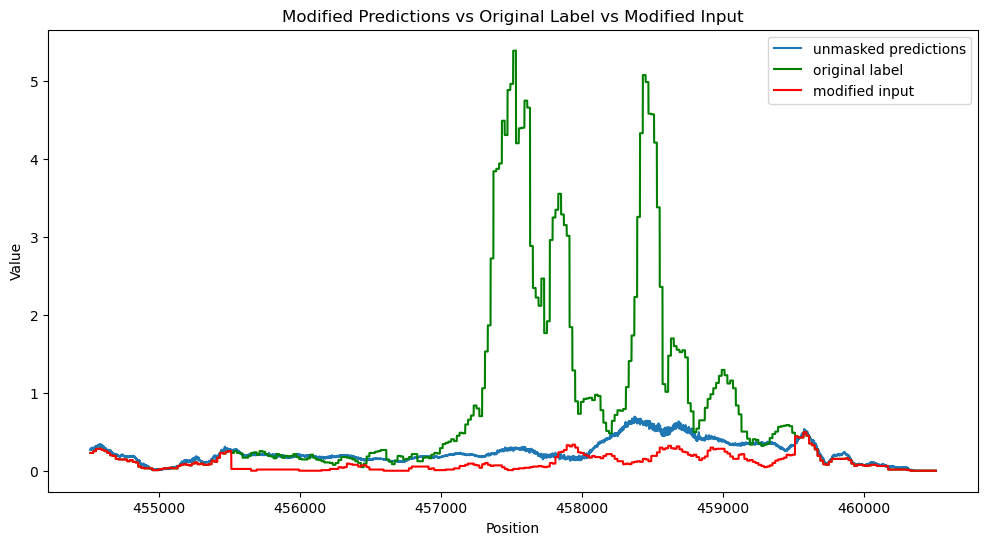

In [34]:
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out2[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out2[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = acc[0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

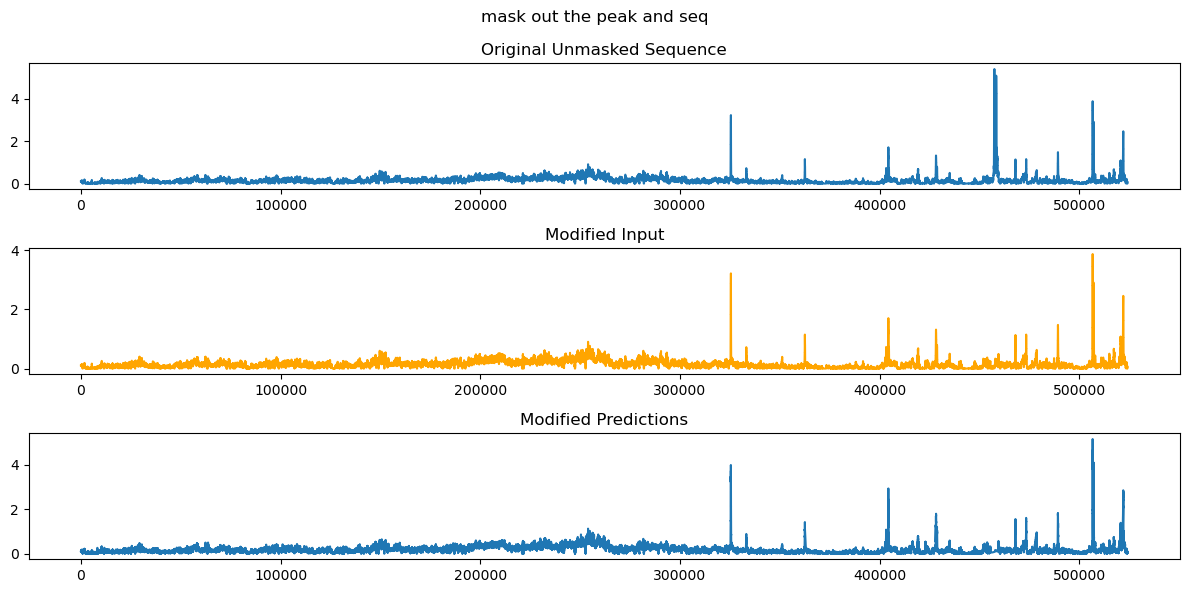

In [43]:
#let's both get rid of the seq but still call it mask

(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15]
acc = acc_unmask.clone()
acc[max_index - 2000 : max_index + 2000, 0] = acc[max_index - 8000 : max_index - 4000, 0] #set to a random value
acc = acc.transpose(1,0)

seq[-1] = 0
acc[-1] = 0

acc[-1,max_index - 2000 : max_index + 2000] = 1 #mask it
seq[-1, max_index - 2000 : max_index + 2000] = 1 #just call it mask, didn't even change the underlying sequence
seq[:5, max_index - 2000 : max_index + 2000] = 0 #just get rid of the sequence, we don't want it to be there

modified_data = (seq, acc, seq_unmask, acc_unmask) #just modify the acc, keep everything else the same
out2 = evals(data = modified_data)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(acc_unmask[:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(acc[0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out2[1][0, :, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()

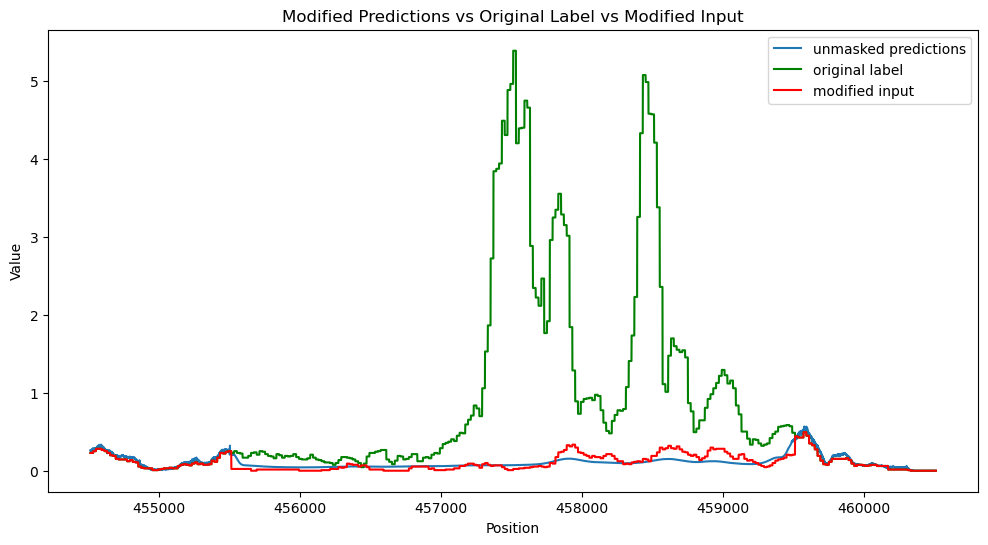

In [44]:
#and do the plot again

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out2[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out2[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = acc[0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

In [ ]:
seq.shape #so must be in shape 6 x 4000

torch.Size([6, 524288])

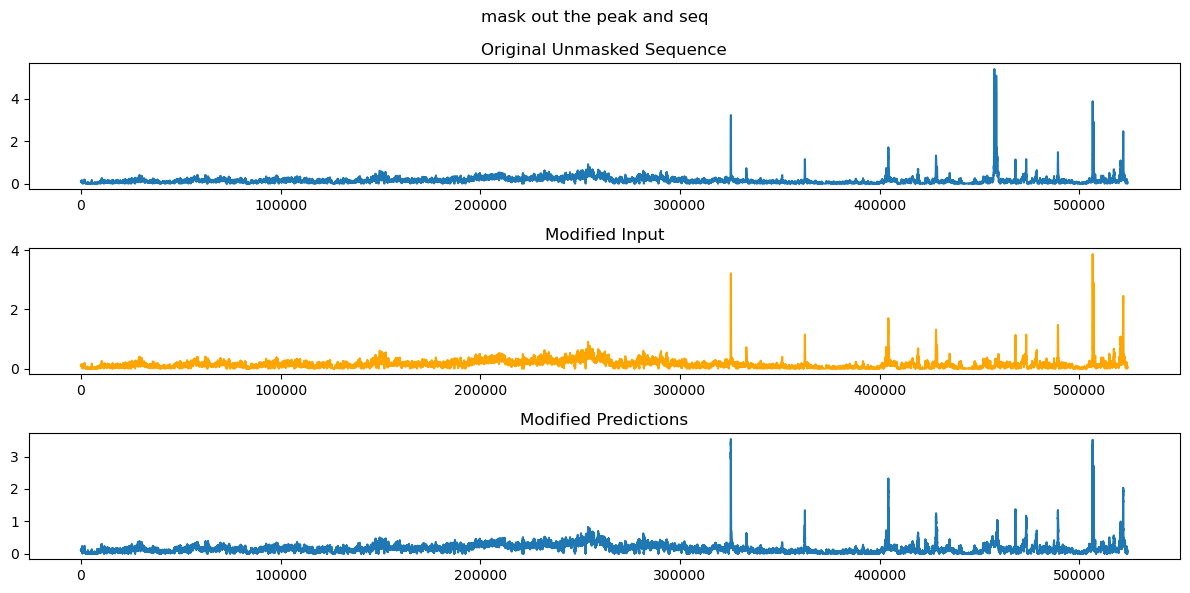

In [46]:
#now let's randomize the sequence
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15]
acc = acc_unmask.clone()
acc[max_index - 2000 : max_index + 2000, 0] = acc[max_index - 8000 : max_index - 4000, 0] #set to a random value
acc = acc.transpose(1,0)

seq = seq_unmask.clone().transpose(1,0) #use the unmasked sequence

seq[-1] = 0
acc[-1] = 0

acc[-1,max_index - 2000 : max_index + 2000] = 1 #mask it
# seq[-1, max_index - 2000 : max_index + 2000] = 1 #mask it
#get random integers for each position we are randomizing, so we need 4000 total
random_indices = torch.randint(0, 4, size=(4000,)) #assuming 4 possible values for the sequence
#and now one hot encode it
one_hot_seq = torch.nn.functional.one_hot(random_indices, num_classes=4) #makes it 4000 x 4
seq[:4, max_index - 2000 : max_index + 2000] = one_hot_seq.T #transpose to get the right shape, now seq is 6 x 4000

modified_data = (seq, acc, seq_unmask, acc_unmask) #just modify the acc, keep everything else the same
out2 = evals(data = modified_data)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(acc_unmask[:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(acc[0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out2[1][0, :, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()

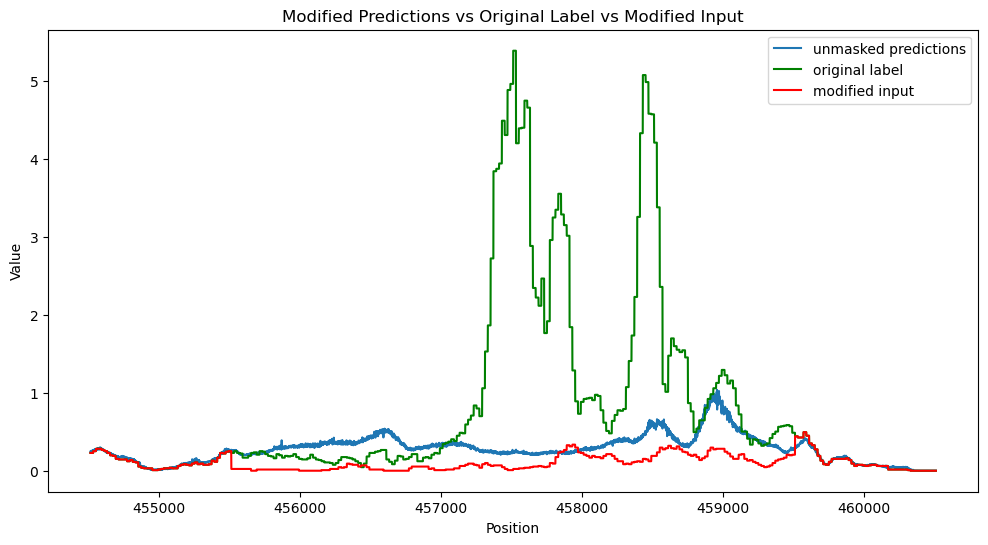

In [47]:
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out2[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out2[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = acc[0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

In [1]:
#I modified my function, let's see if it works so that we can replicate things much simpler!
#we'll try to get the good looking plot

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
evals = Evals(ckpt_path,device=1)

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [8]:
(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15] #get the original data
max_index = acc_unmask[:,0].argmax()

out = evals.mask(max_index-2000,max_index+2000, 15, mask_accessibility=True, randomize_accessibility=True)

In [9]:
np.random.randint(0, 524288 - 1000*1.2)

303478

In [10]:
#let's verifiy shapes
#so the thing out returns is like this: predict seq, predict acc, true seq, true acc, input seq, input acc
for i in range(6):
    print(out[i].shape)

torch.Size([1, 524288, 5])
torch.Size([1, 524288, 1])
torch.Size([524288, 6])
torch.Size([524288, 2])
torch.Size([1, 6, 524288])
torch.Size([1, 2, 524288])


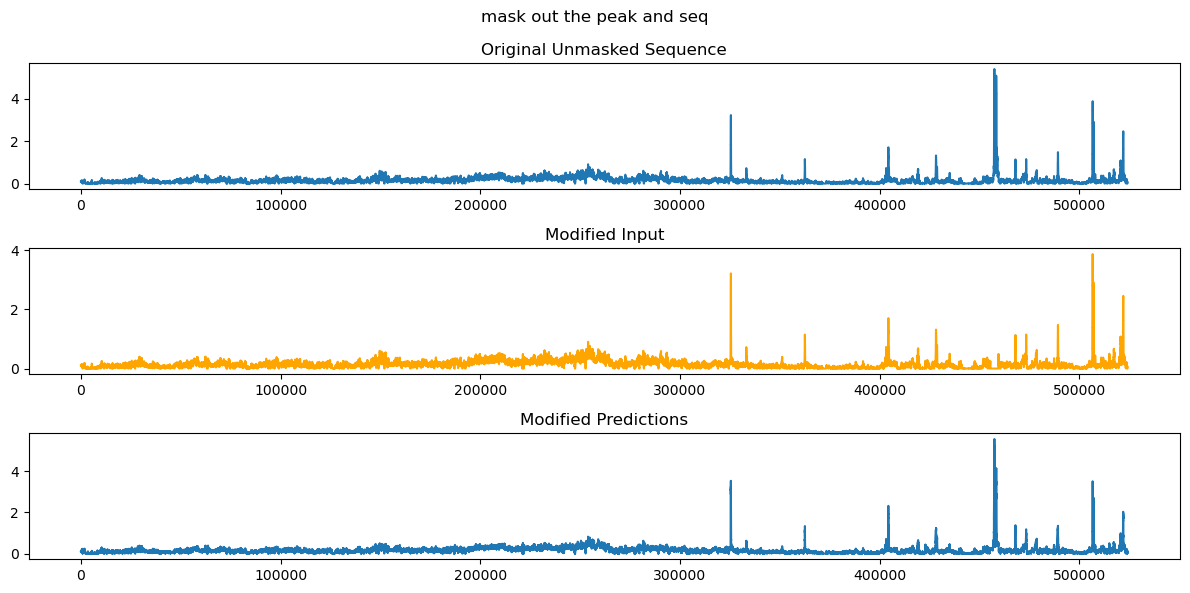

In [11]:
#let's try to replicate the plot using out

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()

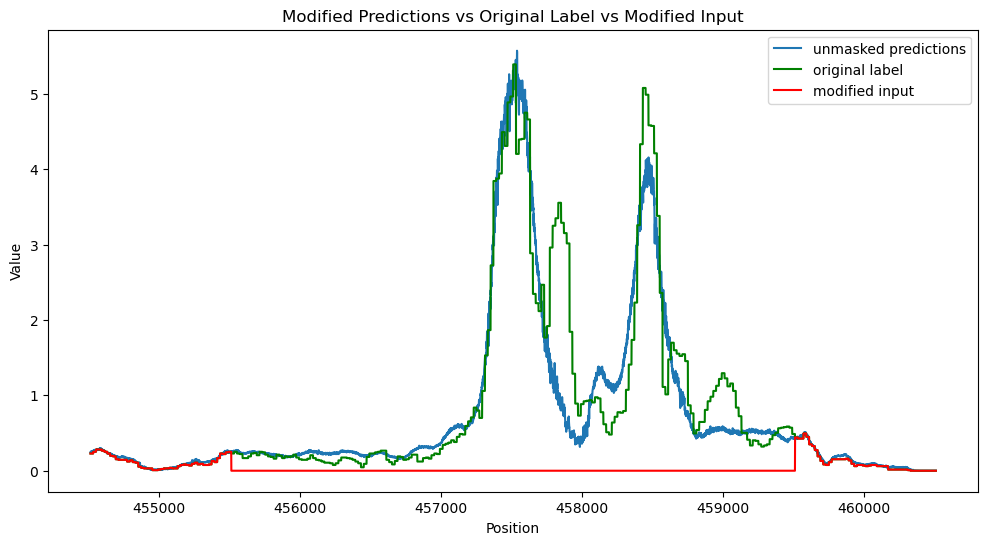

In [12]:
start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

In [ ]:
#let's correlate them
from scipy.stats import pearsonr
pearsonr(y_vals[1000:-1000], y_vals_original[1000:-1000]) #pretty good! shows it's clearly doing fine at least in this peak region!!

PearsonRResult(statistic=0.9094955064301153, pvalue=0.0)

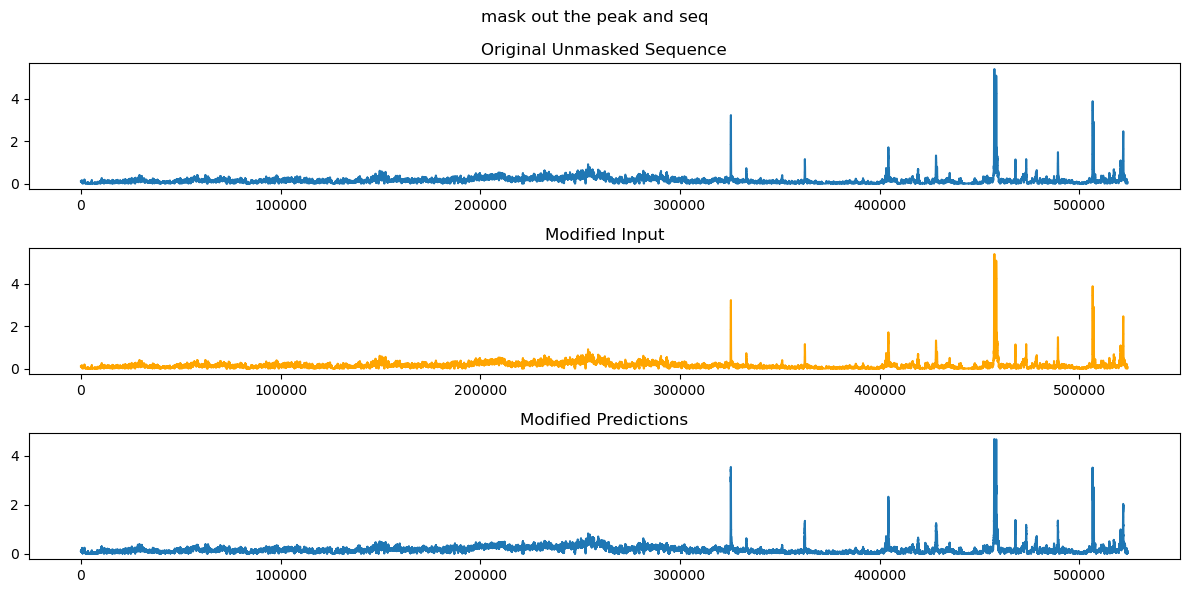

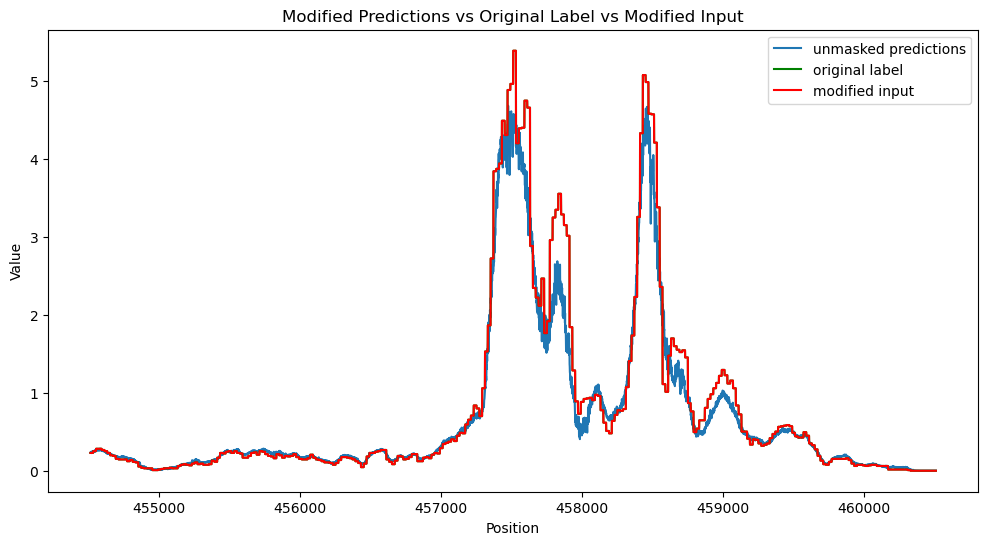

In [7]:
#let's see what happens if we just run this for 
out = evals.mask(max_index-2000,max_index+2000, 15)
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

In [1]:
#final thing is test to see if it works when there's no accessibility information

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
evals = Evals(ckpt_path,device=1)

(seq,acc),(seq_unmask,acc_unmask) = evals.dataset[15] #get the original data
max_index = acc_unmask[:,0].argmax()

acc.shape
# out = evals.mask(0,acc.shape[0], 15, mask_accessibility=True)

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


torch.Size([2, 524288])

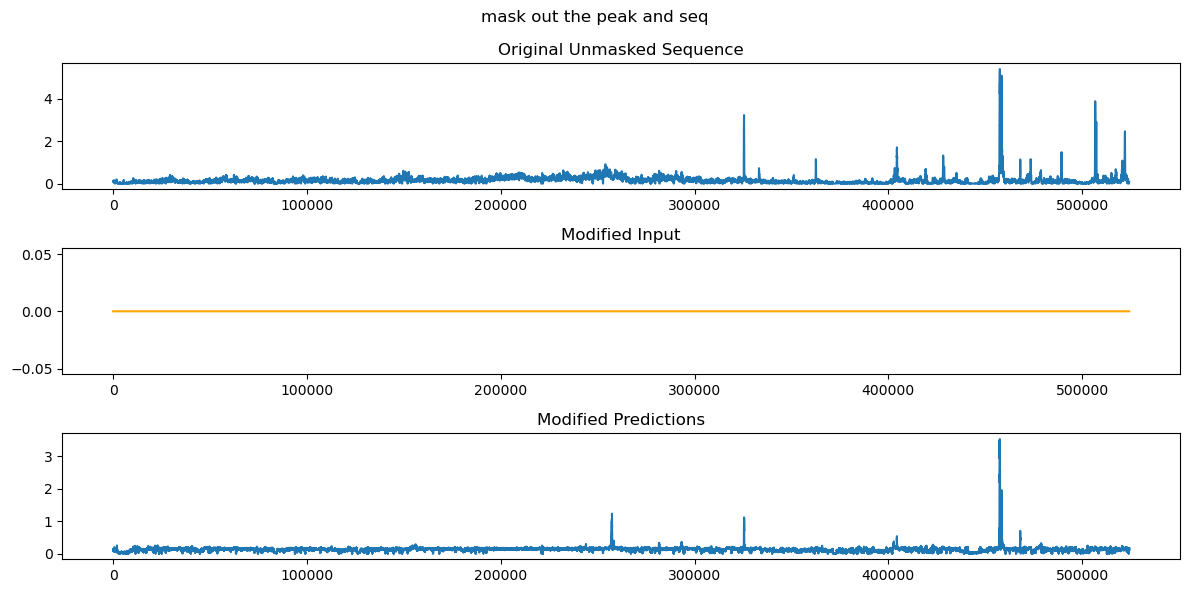

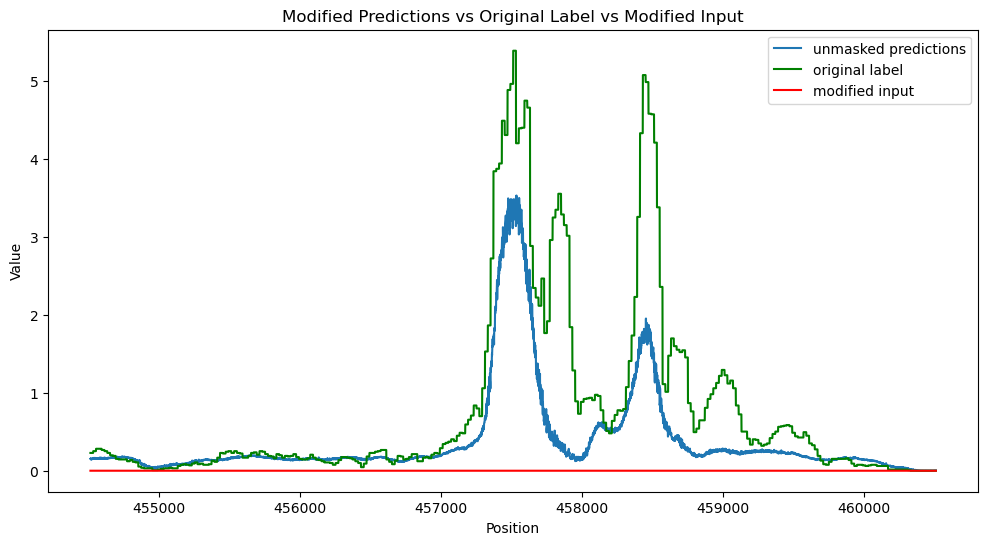

In [2]:
out = evals.mask(0,acc.shape[1], 15, mask_accessibility=True)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

# let's look at a second example

In [9]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
evals = Evals(ckpt_path,device=1)

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


tensor(32246)


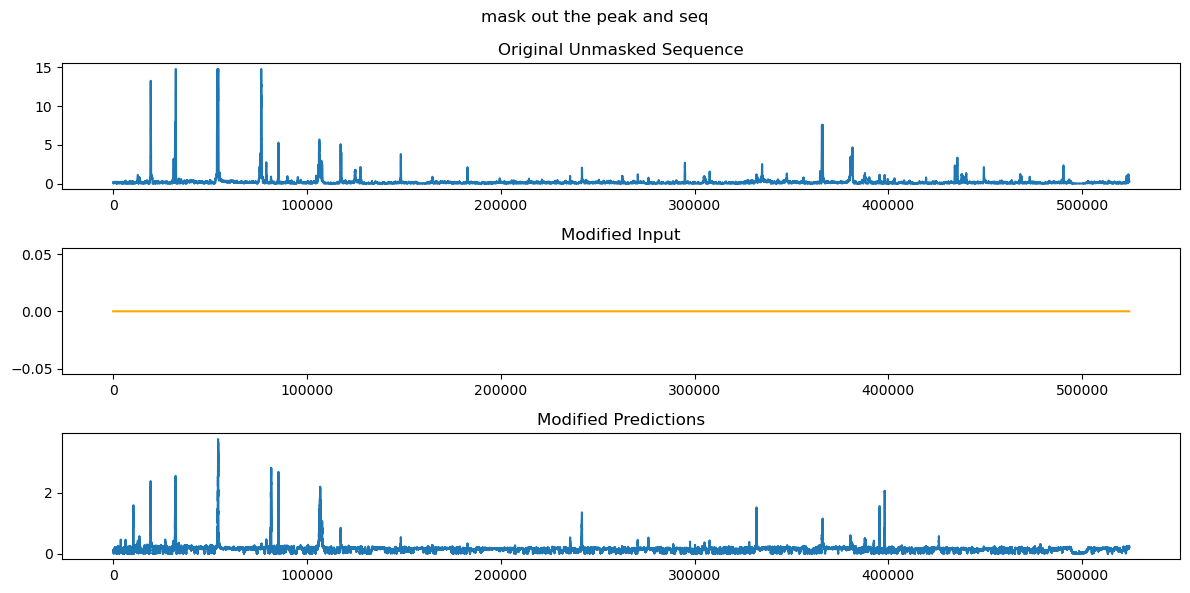

PearsonRResult(statistic=0.9005532125058673, pvalue=0.0)


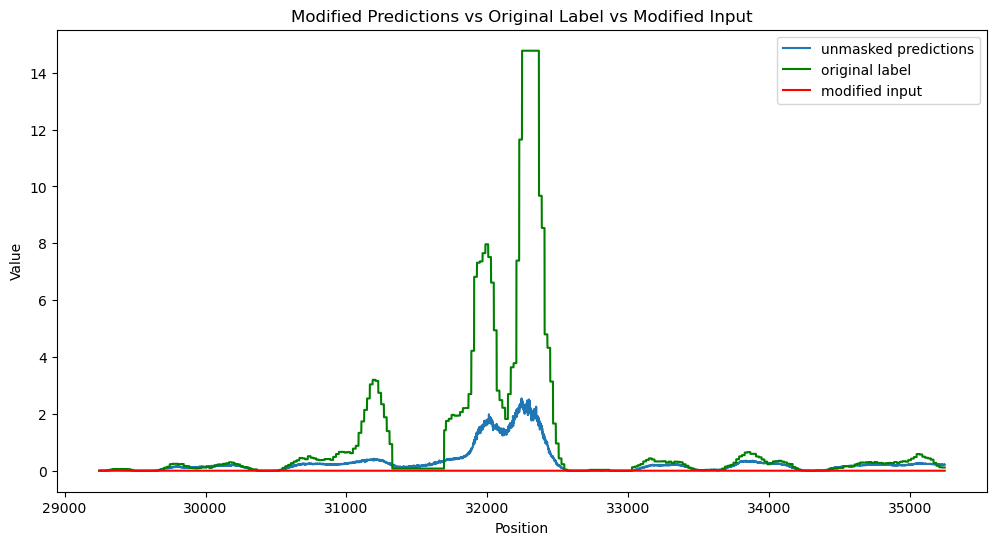

In [10]:
out = evals.mask(0,acc.shape[1], 100, mask_accessibility=True)

max_index = out[3][:, 0].argmax()
print(max_index)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

print(pearsonr(y_vals[1000:-1000], y_vals_original[1000:-1000])) #not as good as before but still pretty good!

tensor(32246)


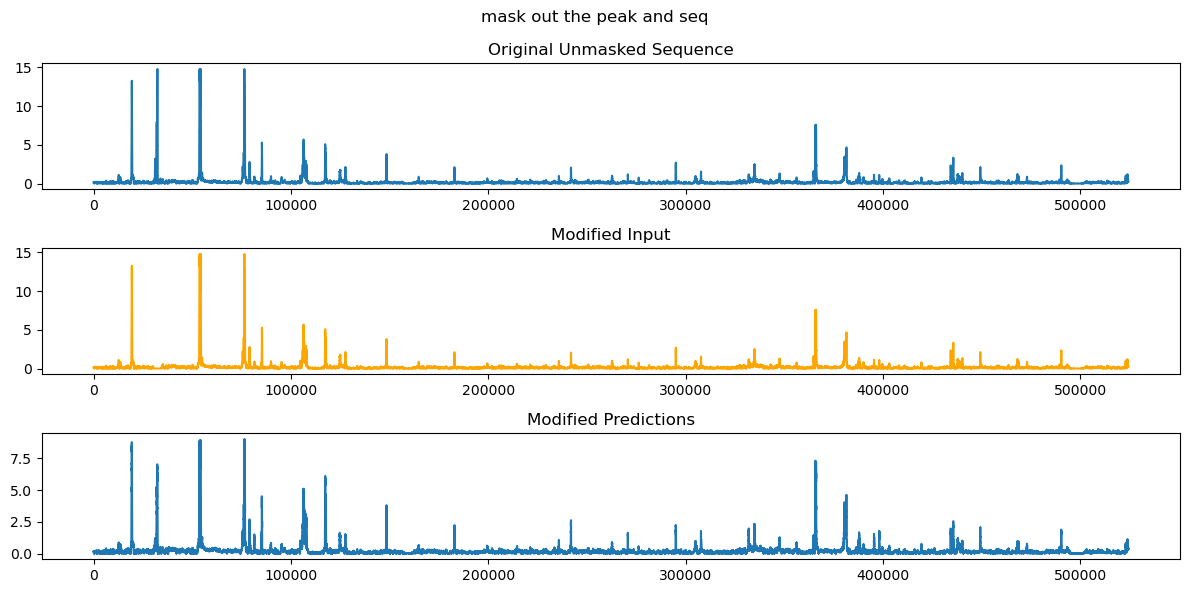

PearsonRResult(statistic=0.9162540548086955, pvalue=0.0)


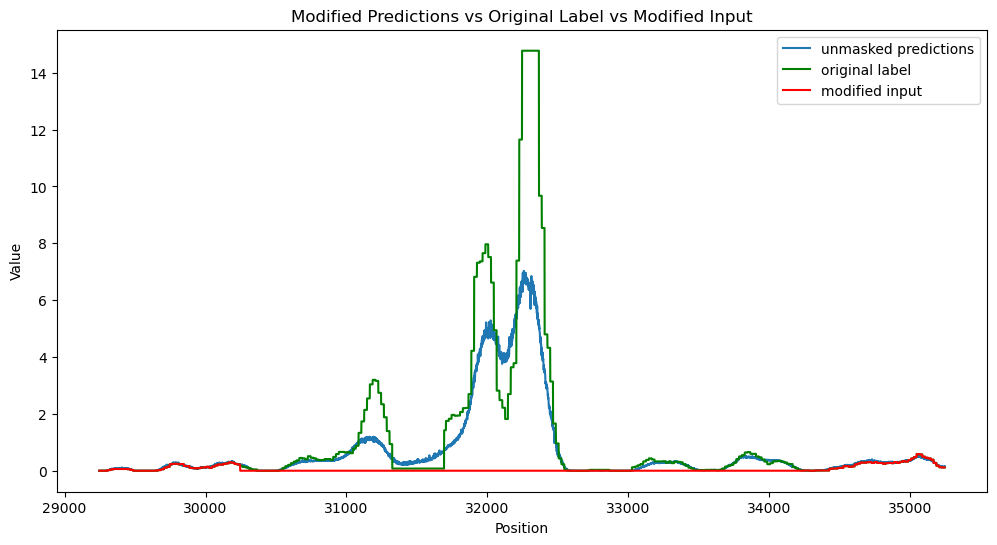

In [11]:
start = max_index - 2000
end = max_index + 2000
out = evals.mask(start,end, 100, mask_accessibility=True)

print(max_index)

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(out[3][:, 0].cpu().numpy(), label='Original Unmasked Sequence')
plt.title('Original Unmasked Sequence')

plt.subplot(3, 1, 2)
plt.plot(out[5][0,0, :].cpu().numpy(), label='Modified Input', color='orange')
plt.title('Modified Input')

plt.subplot(3, 1, 3)
plt.plot(out[1][0,:, 0].cpu().numpy(), label='Modified Predictions')
plt.title('Modified Predictions')

plt.suptitle('mask out the peak and seq')


plt.tight_layout()
plt.show()

start = max_index - 3000
end = max_index + 3000

x_vals = np.arange(start,end)
y_vals = out[1][0, start:end, 0].cpu().numpy()

plt.subplots(figsize=(12, 6))

plt.plot(x_vals, y_vals, label='unmasked predictions')

#and get the actual values
y_vals_original = out[3][:, 0].cpu().numpy()[start:end]
plt.plot(x_vals, y_vals_original, label='original label', color='green')

#and plot the input to the model
y_vals_input = out[5][0,0, start:end].cpu().numpy()
plt.plot(x_vals, y_vals_input, label='modified input', color='red')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Modified Predictions vs Original Label vs Modified Input')
plt.legend()

#let's do pearson correlation
print(pearsonr(y_vals[1000:-1000], y_vals_original[1000:-1000])) #not as good but still decent, shows it's clearly doing fine at least in this peak region!!

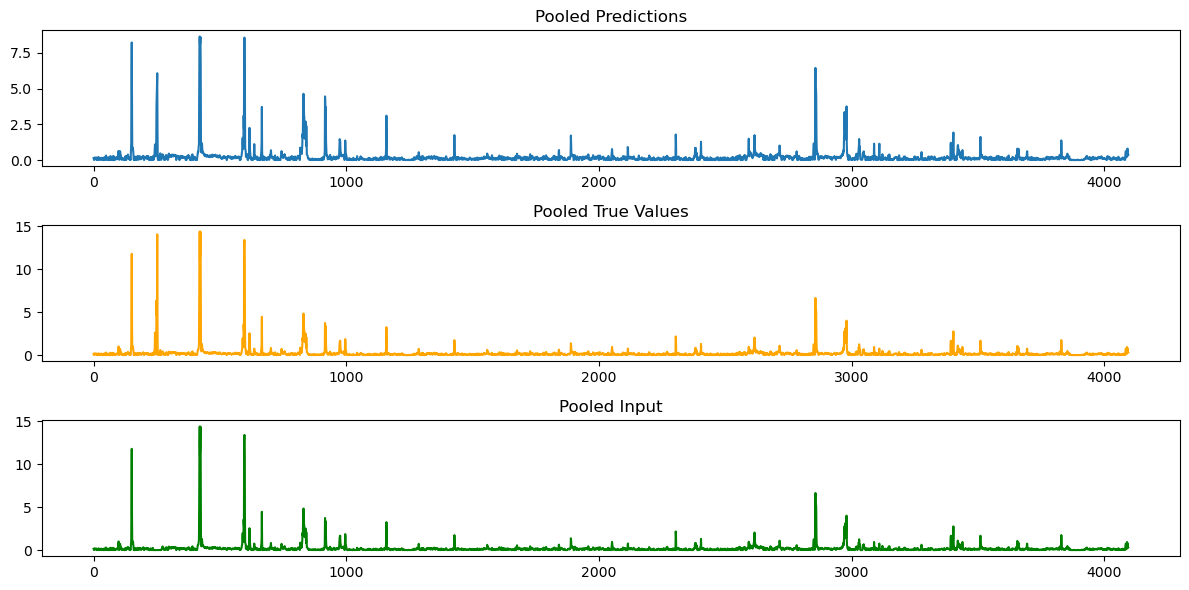

In [16]:
#let's now pool the output at 128 bp resolution and plot it

start = max_index - 2000
end = max_index + 2000
out = evals.mask(start,end, 100, mask_accessibility=True)

pooled_pred = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_true = out[3][:, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_input = out[5][0, 0, :].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(pooled_pred, label='Pooled Predictions')
plt.title('Pooled Predictions')
plt.subplot(3, 1, 2)
plt.plot(pooled_true, label='Pooled True Values', color='orange')
plt.title('Pooled True Values')
plt.subplot(3, 1, 3)
plt.plot(pooled_input, label='Pooled Input', color='green')
plt.title('Pooled Input')
plt.tight_layout()

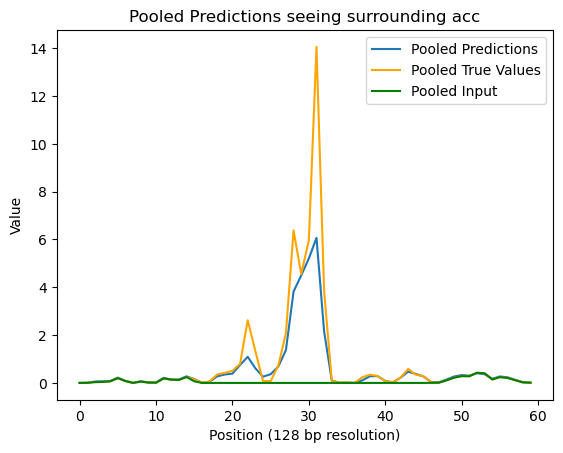

In [22]:
#only interesting to zoom in to the part we care about, let's look around the value
midpoint = max_index//128

start = midpoint - 30
end = midpoint + 30

plt.plot(pooled_pred[start:end], label='Pooled Predictions')
plt.plot(pooled_true[start:end], label='Pooled True Values', color='orange')
plt.plot(pooled_input[start:end], label='Pooled Input', color='green')
plt.xlabel('Position (128 bp resolution)')
plt.ylabel('Value')
plt.title('Pooled Predictions seeing surrounding acc')
plt.legend()

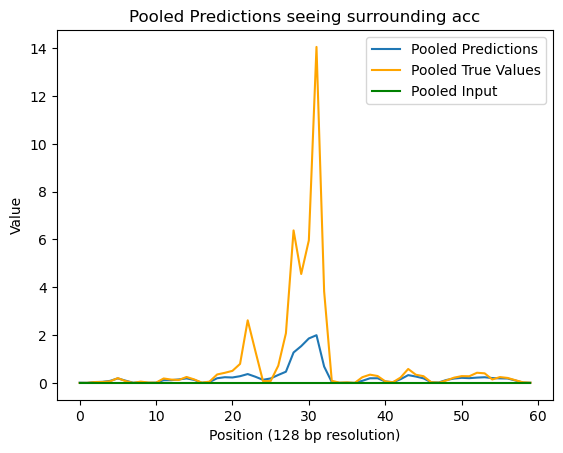

In [25]:
out = evals.mask(0,acc.shape[1], 100, mask_accessibility=True)

pooled_pred = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_true = out[3][:, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_input = out[5][0, 0, :].cpu().numpy().reshape(-1, 128).mean(axis=1)

midpoint = max_index//128

start = midpoint - 30
end = midpoint + 30

plt.plot(pooled_pred[start:end], label='Pooled Predictions')
plt.plot(pooled_true[start:end], label='Pooled True Values', color='orange')
plt.plot(pooled_input[start:end], label='Pooled Input', color='green')
plt.xlabel('Position (128 bp resolution)')
plt.ylabel('Value')
plt.title('Pooled Predictions seeing surrounding acc')
plt.legend()

In [ ]:
#4 tracks, one for enformer, our model with surrounding accessibility, our model with no accessibility, and the original sequence
#let's see what the input is, it's element 100
print(evals.dataset.sequences.iloc[100])
chrom, start, end, split = evals.dataset.sequences.iloc[100]
diff = evals.dataset.length - (end - start)
start = start - diff // 2
print(start)
end = start + 196608
print(end)

#so chr 19 form 54083399 to 54280007

0       chr19
1    54280007
2    54411079
3        test
Name: 100, dtype: object
54083399
54280007


In [30]:
#let's load in the enformer results
enformer_pred = np.load('/data1/lesliec/sarthak/deepmind-research/enformer/random_runs/chr19_54083399.npy')
enformer_pred.shape

(896, 5313)

In [31]:
#let's find the track... it's track 12
enformer_pred = enformer_pred[:,12]
enformer_pred.shape

(896,)

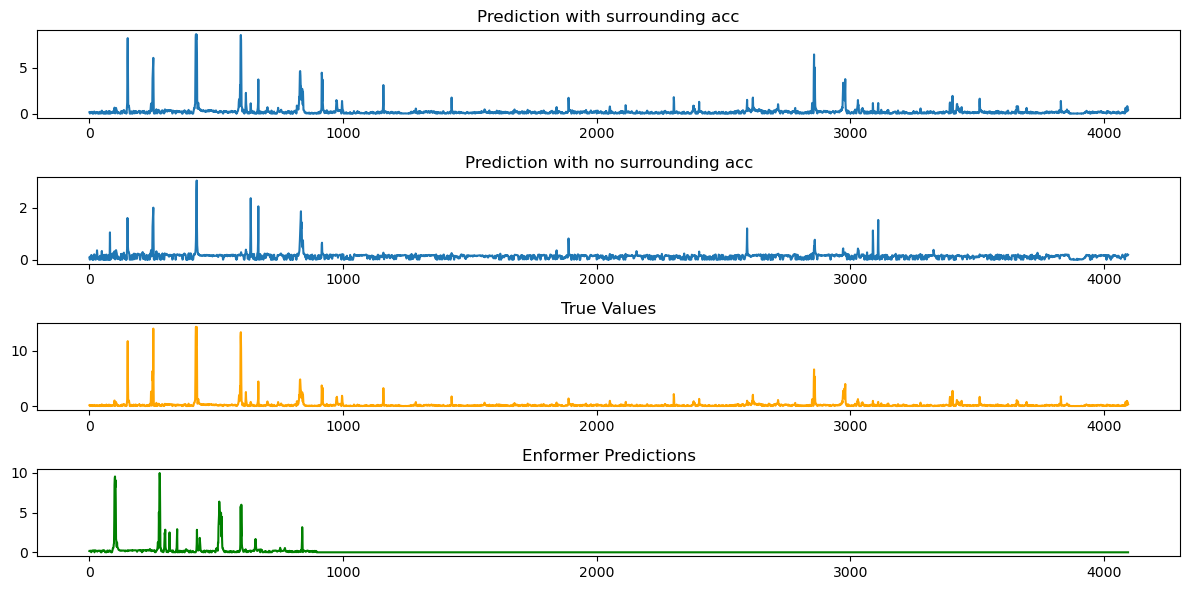

In [35]:
#now let's plot them all together!

start = max_index - 2000
end = max_index + 2000
out = evals.mask(start,end, 100, mask_accessibility=True)

pooled_pred = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_true = out[3][:, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(pooled_pred, label='Pooled Predictions')
plt.title('Prediction with surrounding acc')

out = evals.mask(0,acc.shape[1], 100, mask_accessibility=True)

pooled_pred = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_true = out[3][:, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.subplot(4, 1, 2)
plt.plot(pooled_pred, label='Pooled Predictions')
plt.title('Prediction with no surrounding acc')

plt.subplot(4, 1, 3)
plt.plot(pooled_true, label='Pooled True Values', color='orange')
plt.title('True Values')

full_enformer_pred = np.zeros(pooled_pred.shape)
full_enformer_pred[:enformer_pred.shape[0]] = enformer_pred

plt.subplot(4, 1, 4)
plt.plot(full_enformer_pred, label='Enformer Predictions', color='green')
plt.title('Enformer Predictions')
plt.tight_layout()

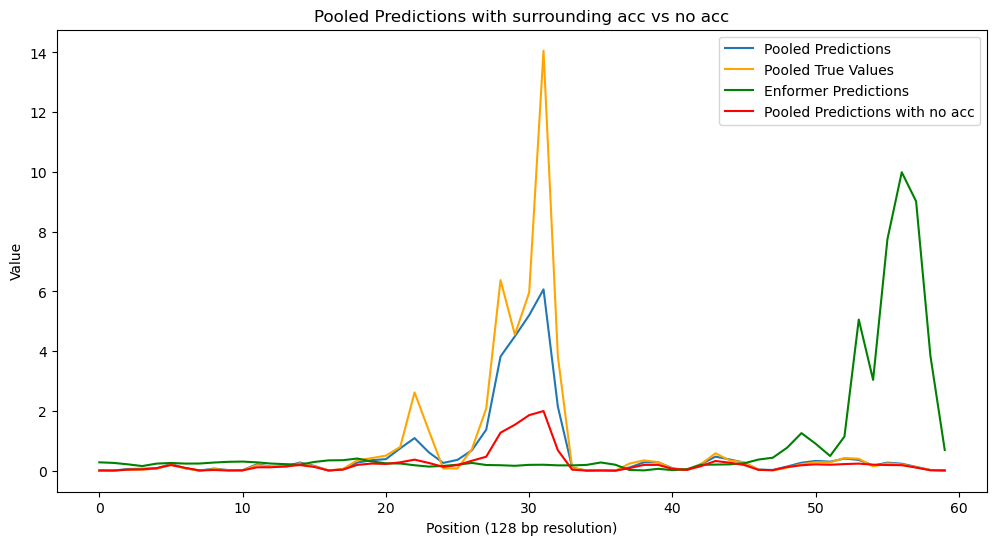

In [40]:
#and let's plot around the midpoint


start = max_index - 2000
end = max_index + 2000
out = evals.mask(start,end, 100, mask_accessibility=True)

midpoint = max_index//128
start = midpoint - 30
end = midpoint + 30
plt.figure(figsize=(12, 6))

pooled_pred_surroundingacc = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.plot(pooled_pred_surroundingacc[start:end], label='Pooled Predictions')
plt.plot(pooled_true[start:end], label='Pooled True Values', color='orange')
plt.plot(full_enformer_pred[start:end], label='Enformer Predictions', color='green')
out = evals.mask(0,acc.shape[1], 100, mask_accessibility=True)
pooled_pred_noacc = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
plt.plot(pooled_pred_noacc[start:end], label='Pooled Predictions with no acc', color='red')
plt.xlabel('Position (128 bp resolution)')
plt.ylabel('Value')
plt.title('Pooled Predictions with surrounding acc vs no acc')
plt.legend()

In [42]:
#did we get the wrong data? let's manually verify things
true_vals = evals.dataset.data['chr19'][0,54083399:54083399+196608]
true_vals.shape

(196608,)

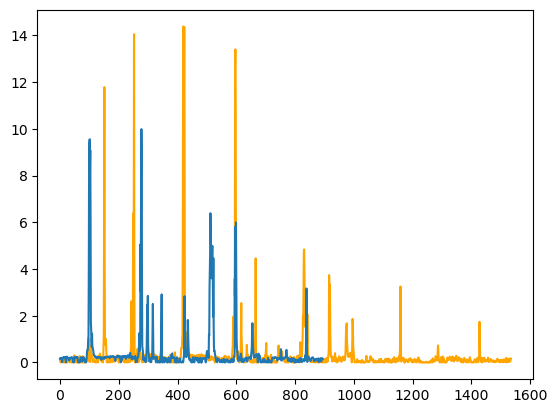

In [45]:
true_vals_pooled = true_vals.reshape(-1, 128).mean(axis=1)
plt.plot(true_vals_pooled, label='True Values', color='orange')
plt.plot(enformer_pred)

In [48]:
print(true_vals_pooled.shape)
print(enformer_pred.shape)

(1536,)
(896,)


In [51]:
print(114688/128,196608/128)

896.0 1536.0


In [52]:
#wait I realized the issue, enformer predicts the middle of the 196608, now the whole thing, let's fix it

enformer_pred_centered = np.zeros(true_vals_pooled.shape)
si = (1536-896)//2
ei = si + enformer_pred.shape[0]
print(si,ei)

320 1216


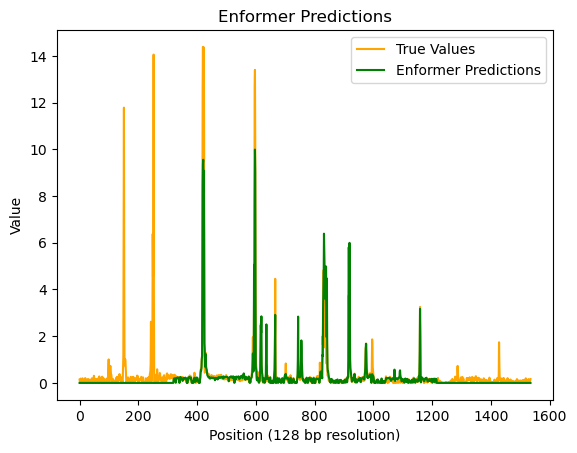

In [57]:
enformer_pred_centered[si:ei] = enformer_pred
plt.plot(true_vals_pooled, label='True Values', color='orange')
plt.plot(enformer_pred_centered, label='Enformer Predictions', color='green')
plt.xlabel('Position (128 bp resolution)')
plt.ylabel('Value')
plt.title('Enformer Predictions')
plt.legend()

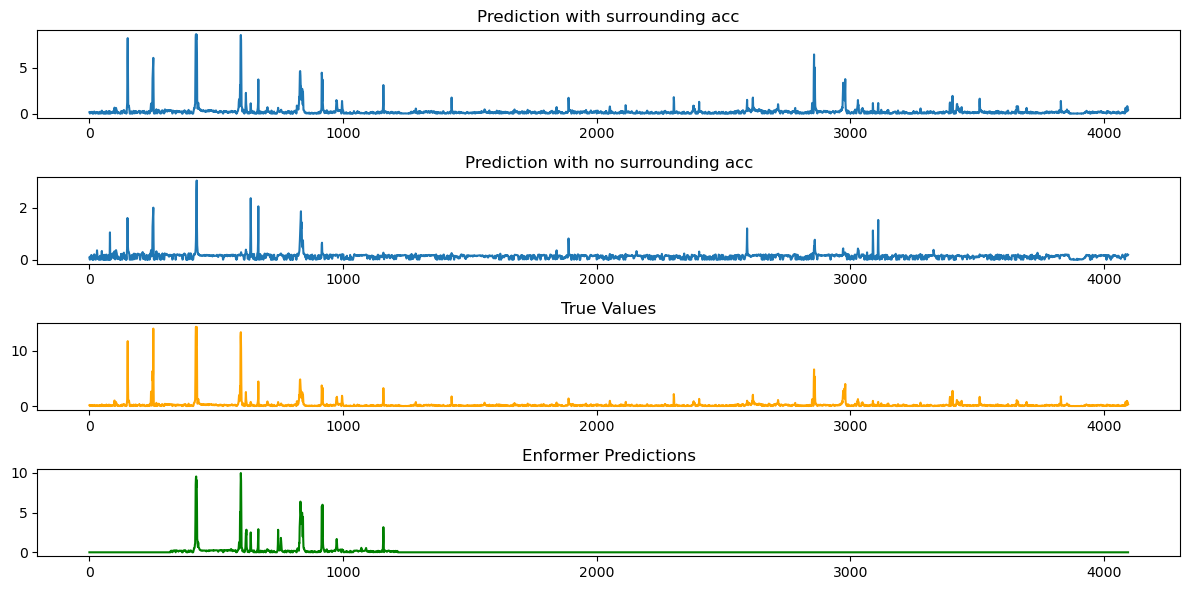

In [55]:
#and let's redo the other plots

start = max_index - 2000
end = max_index + 2000
out = evals.mask(start,end, 100, mask_accessibility=True)

pooled_pred = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_true = out[3][:, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(pooled_pred, label='Pooled Predictions')
plt.title('Prediction with surrounding acc')

out = evals.mask(0,acc.shape[1], 100, mask_accessibility=True)

pooled_pred = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_true = out[3][:, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.subplot(4, 1, 2)
plt.plot(pooled_pred, label='Pooled Predictions')
plt.title('Prediction with no surrounding acc')

plt.subplot(4, 1, 3)
plt.plot(pooled_true, label='Pooled True Values', color='orange')
plt.title('True Values')

full_enformer_pred = np.zeros(pooled_pred.shape)
full_enformer_pred[:enformer_pred_centered.shape[0]] = enformer_pred_centered

plt.subplot(4, 1, 4)
plt.plot(full_enformer_pred, label='Enformer Predictions', color='green')
plt.title('Enformer Predictions')
plt.tight_layout()

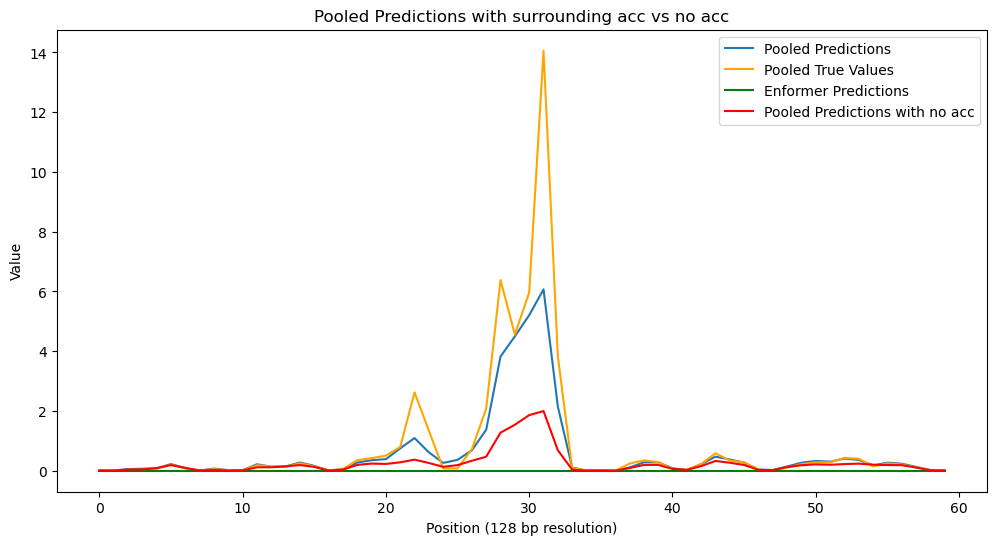

In [56]:
start = max_index - 2000
end = max_index + 2000
out = evals.mask(start,end, 100, mask_accessibility=True)

midpoint = max_index//128
start = midpoint - 30
end = midpoint + 30
plt.figure(figsize=(12, 6))

pooled_pred_surroundingacc = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.plot(pooled_pred_surroundingacc[start:end], label='Pooled Predictions')
plt.plot(pooled_true[start:end], label='Pooled True Values', color='orange')
plt.plot(full_enformer_pred[start:end], label='Enformer Predictions', color='green')
out = evals.mask(0,acc.shape[1], 100, mask_accessibility=True)
pooled_pred_noacc = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
plt.plot(pooled_pred_noacc[start:end], label='Pooled Predictions with no acc', color='red')
plt.xlabel('Position (128 bp resolution)')
plt.ylabel('Value')
plt.title('Pooled Predictions with surrounding acc vs no acc')
plt.legend()

In [58]:
#let's do this again, but now we will chagne where our mask is applied and compare to enformer there
#find maxx of pooled data
max_index = pooled_pred.argmax()
print(max_index)

423


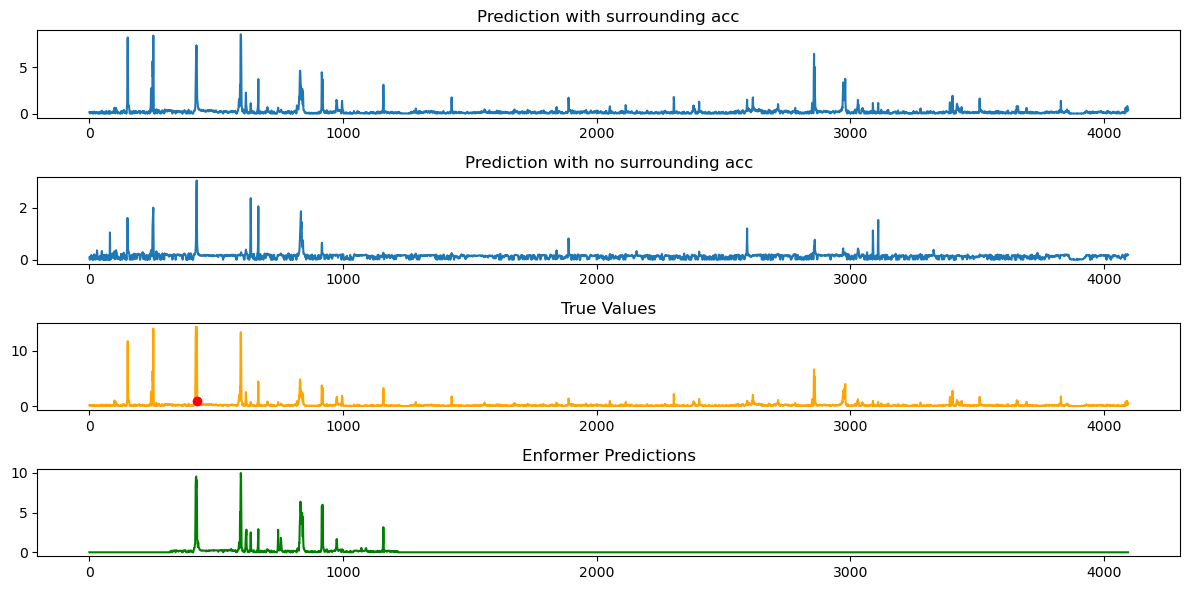

In [63]:
#so in the original data that's 423*128 = 54144
#so let's mask out the region around it
start = 54144 - 2000
end = 54144 + 2000

out = evals.mask(start,end, 100, mask_accessibility=True)

pooled_pred = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_true = out[3][:, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(pooled_pred, label='Pooled Predictions')
plt.title('Prediction with surrounding acc')

out = evals.mask(0,acc.shape[1], 100, mask_accessibility=True)

pooled_pred = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
pooled_true = out[3][:, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.subplot(4, 1, 2)
plt.plot(pooled_pred, label='Pooled Predictions')
plt.title('Prediction with no surrounding acc')

plt.subplot(4, 1, 3)
plt.plot(pooled_true, label='Pooled True Values', color='orange')
plt.title('True Values')
#also plot on there the values that are covered
plt.plot((54144)//128, 1, 'ro', label='Masked True Value')

full_enformer_pred = np.zeros(pooled_pred.shape)
full_enformer_pred[:enformer_pred_centered.shape[0]] = enformer_pred_centered

plt.subplot(4, 1, 4)
plt.plot(full_enformer_pred, label='Enformer Predictions', color='green')
plt.title('Enformer Predictions')
plt.tight_layout()

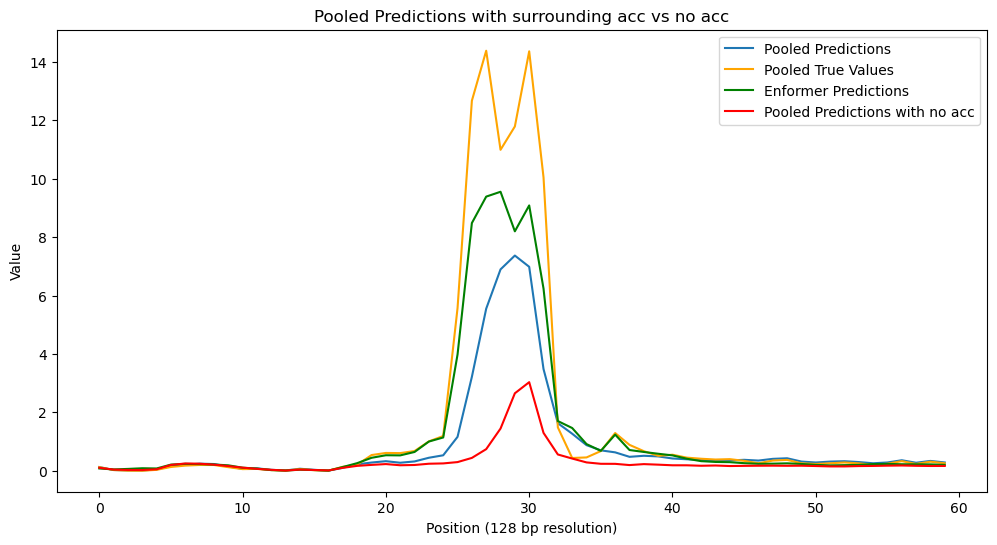

In [65]:
start = 54144 - 2000
end = 54144 + 2000
out = evals.mask(start,end, 100, mask_accessibility=True)

midpoint = max_index
start = midpoint - 30
end = midpoint + 30
plt.figure(figsize=(12, 6))

pooled_pred_surroundingacc = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)

plt.plot(pooled_pred_surroundingacc[start:end], label='Pooled Predictions')
plt.plot(pooled_true[start:end], label='Pooled True Values', color='orange')
plt.plot(full_enformer_pred[start:end], label='Enformer Predictions', color='green')
out = evals.mask(0,acc.shape[1], 100, mask_accessibility=True)
pooled_pred_noacc = out[1][0, :, 0].cpu().numpy().reshape(-1, 128).mean(axis=1)
plt.plot(pooled_pred_noacc[start:end], label='Pooled Predictions with no acc', color='red')
plt.xlabel('Position (128 bp resolution)')
plt.ylabel('Value')
plt.title('Pooled Predictions with surrounding acc vs no acc')
plt.legend()

# and now figure out sequence

In [1]:
#obviously for random regions it won't be good, let's try checking regions with coding regions to see if it learns that better?
#no it must be motifs it learns better? let's try a few regions to see

#first a question of how to plot it, let's see what the output is

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
evals = Evals(ckpt_path,device=1)

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [2]:
out = evals(100)
for i in range(4):
    print(out[i].shape)

torch.Size([1, 524288, 5])
torch.Size([1, 524288, 1])
torch.Size([524288, 6])
torch.Size([524288, 2])


In [ ]:
out[0][0].sum(0) #you can see that it basically doesn't use the last column at all, let's sum probabilities

tensor([  153830.6094,   107047.2891,   113920.6875,   165375.4531,
        -6823308.0000], device='cuda:1')

In [4]:
softmaxed = torch.nn.functional.softmax(out[0][0], dim=1)
softmaxed.sum(0)

tensor([1.2790e+05, 1.3184e+05, 1.3393e+05, 1.3061e+05, 5.9618e+00],
       device='cuda:1')

In [5]:
softmaxed.sum(1).max() #yeah so clearly sums probability to 1 along that dimension

tensor(1.0000, device='cuda:1')

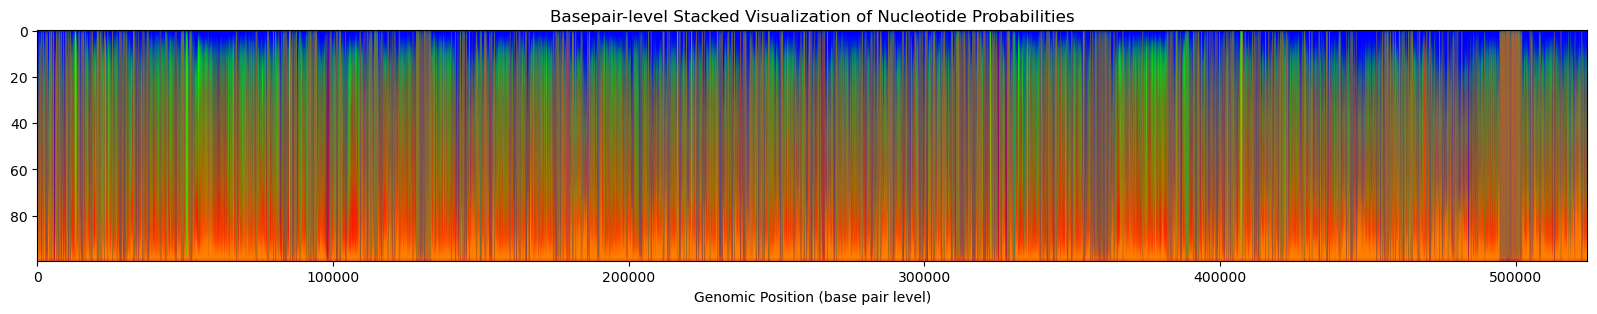

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# For demonstration, generate dummy predictions for 524000 base pairs and 5 nucleotides (A, C, G, T, N)
# Replace this with your actual (524000, 5) softmaxed predictions
# predictions = np.random.dirichlet(np.ones(5), size=524000)
predictions = softmaxed.cpu().numpy()

# Define colors for each nucleotide (as RGB arrays)
colors = {
    'A': np.array([0, 0, 1]),    # Blue
    'C': np.array([0, 1, 0]),    # Green
    'G': np.array([1, 0, 0]),    # Red
    'T': np.array([1, 0.5, 0]),  # Orange
    'N': np.array([0.5, 0, 0.5]) # Purple
}
nucleotides = ['A', 'C', 'G', 'T', 'N']

# Define the height (in pixels) for each column. This controls the vertical resolution.
# A higher value gives a smoother representation of the probabilities.
height = 100

# Create an empty image array: shape (height, number_of_basepairs, 3) for RGB channels.
image = np.zeros((height, predictions.shape[0], 3))

# For each base pair (each column), fill vertical segments according to the cumulative probabilities.
for i in range(predictions.shape[0]):
    cumulative = 0
    for j, nucleotide in enumerate(nucleotides):
        # Calculate the height (in pixels) for the current nucleotide
        prob = predictions[i, j]
        segment_height = int(np.round(prob * height))
        # Ensure we don't exceed the image height (adjust for rounding issues)
        if cumulative + segment_height > height:
            segment_height = height - cumulative
        # Fill the segment with the nucleotide's color
        image[cumulative:cumulative+segment_height, i, :] = colors[nucleotide]
        cumulative += segment_height
    # If there are any remaining pixels (due to rounding), fill them with the last nucleotide color
    if cumulative < height:
        image[cumulative:, i, :] = colors[nucleotides[-1]]

# Plot the generated image
plt.figure(figsize=(20, 3))
plt.imshow(image, aspect='auto')
plt.xlabel("Genomic Position (base pair level)")
plt.title("Basepair-level Stacked Visualization of Nucleotide Probabilities")
plt.show()


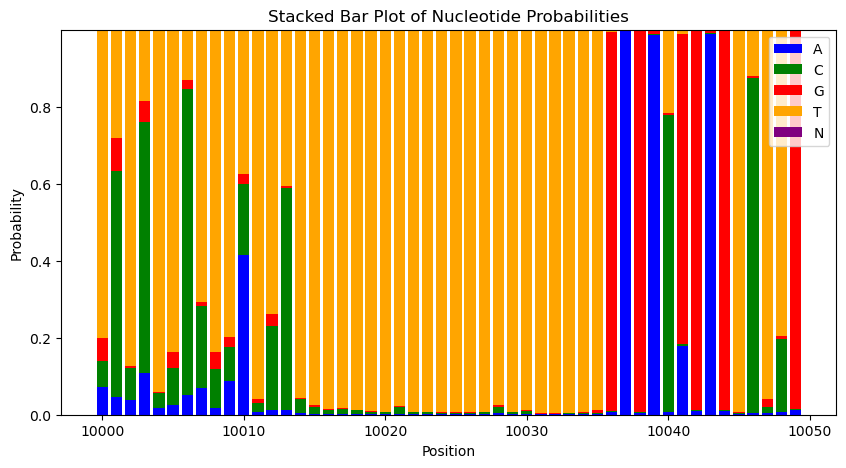

In [10]:
#Yeah I think it doesn't make sense to zoom out, let's look at it zoomed in


# For demonstration, generate dummy data (replace with your softmaxed predictions)
# predictions: shape (524000, 5) where columns represent A, C, G, T, N
predictions = softmaxed.cpu().numpy()

# Define nucleotides and corresponding colors
nucleotides = ['A', 'C', 'G', 'T', 'N']
colors = ['blue', 'green', 'red', 'orange', 'purple']

# Choose a window of positions to visualize (e.g., positions 10000 to 10050)
start, end = 10000, 10050
subset = predictions[start:end]
positions = np.arange(start, end)

# Initialize the bottom array for stacking
bottom = np.zeros(len(subset))

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(5):
    ax.bar(positions, subset[:, i], bottom=bottom, color=colors[i], label=nucleotides[i])
    bottom += subset[:, i]

ax.set_xlabel('Position')
ax.set_ylabel('Probability')
ax.set_title('Stacked Bar Plot of Nucleotide Probabilities')
ax.legend()
plt.show()


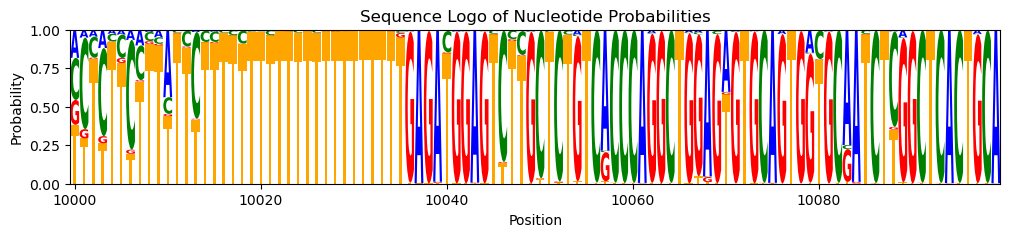

In [10]:
#this is just a worse logoplot, let's do that, let's use the logoplot package
import logomaker
import pandas as pd

predictions = softmaxed.cpu().numpy()

nucleotides = ['A', 'C', 'G', 'T', 'N']
color_dict = {'A': 'blue', 'C': 'green', 'G': 'red', 'T': 'orange', 'N': 'purple'}

# Choose a window of positions to visualize (e.g., positions 10000 to 10050)
start, end = 10000, 10100
subset = predictions[start:end]
positions = np.arange(start, end)

# Create a DataFrame for logomaker with nucleotides as columns and positions as index.
# Each value represents the height of the corresponding nucleotide.
df = pd.DataFrame(subset, columns=nucleotides, index=positions)

# Create the sequence logo using logomaker.
# By setting stack_order='fixed', we preserve the order of nucleotides (A, C, G, T, N)
fig, ax = plt.subplots(figsize=(12, 2))
logo = logomaker.Logo(df, ax=ax, color_scheme=color_dict, stack_order='fixed')

ax.set_xlabel('Position')
ax.set_ylabel('Probability')
ax.set_title('Sequence Logo of Nucleotide Probabilities')
plt.show()

In [12]:
#let's look at random regions and see how well the probability matches the nucleotide
#we'll also test it with first let model see everything

out = evals.mask(0,0, 100)
softmaxed = torch.nn.functional.softmax(out[0][0], dim=1)
softmaxed.shape

torch.Size([524288, 5])

In [ ]:
out[2].shape #includes the mask we want to exclude

torch.Size([524288, 6])

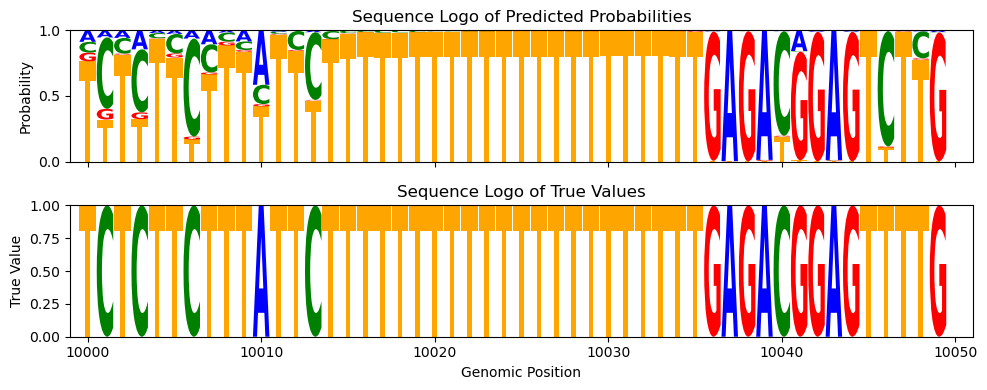

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker

true_values = out[2][:,:5].cpu().numpy()
softmaxed_data = softmaxed.cpu().numpy()

# Define nucleotides and corresponding colors.
nucleotides = ['A', 'C', 'G', 'T', 'N']
color_dict = {'A': 'blue', 'C': 'green', 'G': 'red', 'T': 'orange', 'N': 'purple'}

# Choose a window of positions to visualize (e.g., positions 10000 to 10050)
start, end = 10000, 10050
# subset = softmaxed_data[start:end]
# true_values = true_values[start:end]
positions = np.arange(start, end)

# Create DataFrames for both predicted probabilities and true values.
df_softmax = pd.DataFrame(softmaxed_data[start:end], columns=nucleotides, index=positions)
df_true = pd.DataFrame(true_values[start:end], columns=nucleotides, index=positions)

# Create two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 4))

# Top plot: Predicted probabilities using logomaker.
logo1 = logomaker.Logo(df_softmax, ax=ax1, color_scheme=color_dict, stack_order='fixed')
ax1.set_ylabel("Probability")
ax1.set_title("Sequence Logo of Predicted Probabilities")

# Bottom plot: True values using logomaker.
logo2 = logomaker.Logo(df_true, ax=ax2, color_scheme=color_dict, stack_order='fixed')
ax2.set_xlabel("Genomic Position")
ax2.set_ylabel("True Value")
ax2.set_title("Sequence Logo of True Values")

#set xxlim
plt.xlim(start-1, end+1)

plt.tight_layout()
plt.show()


In [27]:
#let's find where the argmax differs in softmaxxed
argmax = softmaxed.argmax(dim=1)
argmax.shape

torch.Size([524288])

In [32]:
argmax[:10]

tensor([0, 0, 1, 0, 0, 2, 2, 0, 0, 3], device='cuda:1')

In [ ]:
softmaxed[:10] #yeah seems accurate enough

tensor([[6.2634e-01, 1.5499e-01, 1.0071e-01, 1.1796e-01, 3.1501e-08],
        [6.2237e-01, 1.0352e-01, 1.6491e-01, 1.0920e-01, 1.6490e-07],
        [2.5042e-01, 4.6216e-01, 1.3981e-01, 1.4761e-01, 3.7738e-07],
        [7.6420e-01, 1.2303e-01, 1.5968e-02, 9.6793e-02, 3.4730e-07],
        [6.9459e-01, 2.5204e-02, 1.2985e-01, 1.5036e-01, 1.9896e-07],
        [2.2842e-01, 1.2837e-02, 5.9894e-01, 1.5980e-01, 6.0433e-07],
        [2.4777e-01, 9.9267e-02, 5.3780e-01, 1.1516e-01, 4.3767e-07],
        [7.1619e-01, 1.1218e-01, 8.3636e-02, 8.7995e-02, 2.9170e-07],
        [7.9577e-01, 5.6426e-02, 7.2751e-02, 7.5052e-02, 3.4270e-07],
        [2.7955e-01, 9.1847e-02, 1.1120e-01, 5.1740e-01, 2.1236e-07]],
       device='cuda:1')

In [38]:
true_argmax = out[2][:,:5].argmax(dim=1)

In [39]:
true_argmax.shape

torch.Size([524288])

In [41]:
#now find the number of elements where they differ
diff = argmax.cpu() != true_argmax
diff.sum()

tensor(33017)

In [47]:
#let's look at a region with a lot of differences
#let's bin diff and then plot
diff_binned = diff.cpu().numpy().reshape(-1, 128).sum(axis=1)
diff_binned.shape

(4096,)

Text(0.5, 1.0, 'Number of Differences in Argmax between Predicted and True Values')

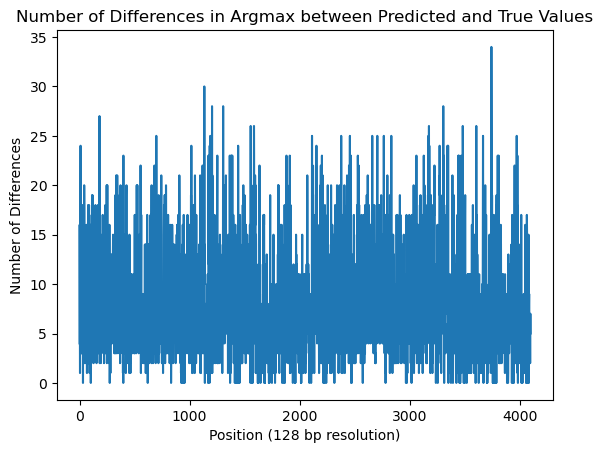

In [53]:
plt.plot(diff_binned)
plt.xlabel('Position (128 bp resolution)')
plt.ylabel('Number of Differences')
plt.title('Number of Differences in Argmax between Predicted and True Values')

In [50]:
#let's find the argmax
diff_binned.argmax()

3740

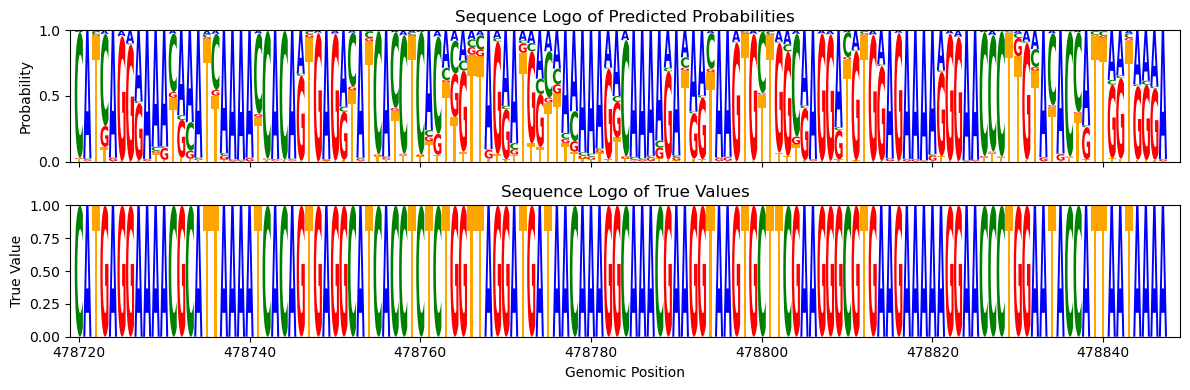

In [52]:
#let's plot around there

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker

true_values = out[2][:,:5].cpu().numpy()
softmaxed_data = softmaxed.cpu().numpy()

# Define nucleotides and corresponding colors.
nucleotides = ['A', 'C', 'G', 'T', 'N']
color_dict = {'A': 'blue', 'C': 'green', 'G': 'red', 'T': 'orange', 'N': 'purple'}

# Choose a window of positions to visualize (e.g., positions 10000 to 10050)
start, end = 3740*128, 3741*128
# subset = softmaxed_data[start:end]
# true_values = true_values[start:end]
positions = np.arange(start, end)

# Create DataFrames for both predicted probabilities and true values.
df_softmax = pd.DataFrame(softmaxed_data[start:end], columns=nucleotides, index=positions)
df_true = pd.DataFrame(true_values[start:end], columns=nucleotides, index=positions)

# Create two subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12, 4))

# Top plot: Predicted probabilities using logomaker.
logo1 = logomaker.Logo(df_softmax, ax=ax1, color_scheme=color_dict, stack_order='fixed')
ax1.set_ylabel("Probability")
ax1.set_title("Sequence Logo of Predicted Probabilities")

# Bottom plot: True values using logomaker.
logo2 = logomaker.Logo(df_true, ax=ax2, color_scheme=color_dict, stack_order='fixed')
ax2.set_xlabel("Genomic Position")
ax2.set_ylabel("True Value")
ax2.set_title("Sequence Logo of True Values")

#set xxlim
plt.xlim(start-1, end+1)

plt.tight_layout()
plt.show()

In [ ]:
#now let's look at hiding the sequence and seeing if it can predict the nucleotide
#doing this is hard, let's just hide SPI1 I guess?
#we can find a spi1 motif by using the chipseq data I think
#chatgpt claims there's one here: chr5:149,710,000–149,710,006
evals.dataset.genome['chr5'][149710000:149710006] #CTTTAA is clearly not spi1?
#let's just look at chipseq

array([ 8, 10, 10, 10,  7,  7], dtype=int8)

In [55]:
import pyBigWig
#the bigwig file name is ENCFF998DST
bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')
bw.values('chr5', 149710000, 149710006) #0.0 is clearly not spi1

[0.9653300046920776,
 0.9653300046920776,
 0.9653300046920776,
 0.9653300046920776,
 0.9653300046920776,
 0.9653300046920776]

In [57]:
#let's just look at the specific sequence for 100
print(evals.dataset.sequences.iloc[100])
chrom, start, end, split = evals.dataset.sequences.iloc[100]
diff = evals.dataset.length - (end - start)
start = start - diff // 2
print(start)
end = start + evals.dataset.length
print(end)

0       chr19
1    54280007
2    54411079
3        test
Name: 100, dtype: object
54083399
54607687


In [58]:
54607687-54083399

524288

In [59]:
#now let's look at this in the chipseq
values = np.array(bw.values('chr19', 54083399, 54607687)) #seems like there's a lot of spi1 here
values.shape

(524288,)

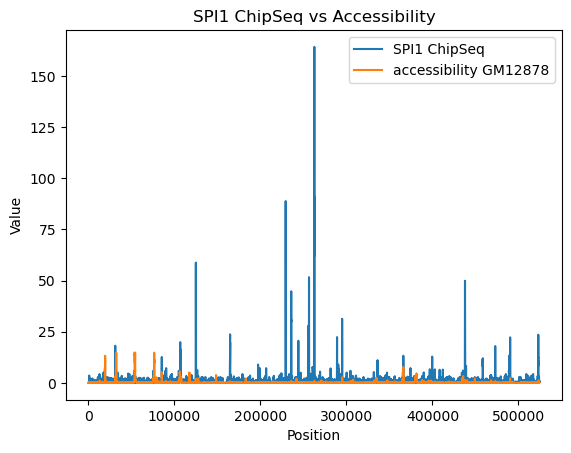

In [65]:
plt.plot(values, label='SPI1 ChipSeq')
plt.plot(evals.dataset.data['chr19'][0,54083399:54607687], label='accessibility GM12878')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

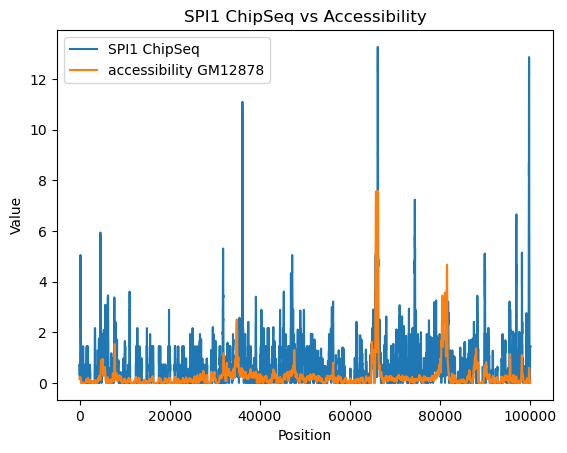

In [68]:
#let's zoom in
plt.plot(values[300_000:400_000], label='SPI1 ChipSeq')
plt.plot(evals.dataset.data['chr19'][0,54083399:54607687][300_000:400_000], label='accessibility GM12878')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [67]:
#let's find the argmax
values[300_000:400_000].argmax()

66132

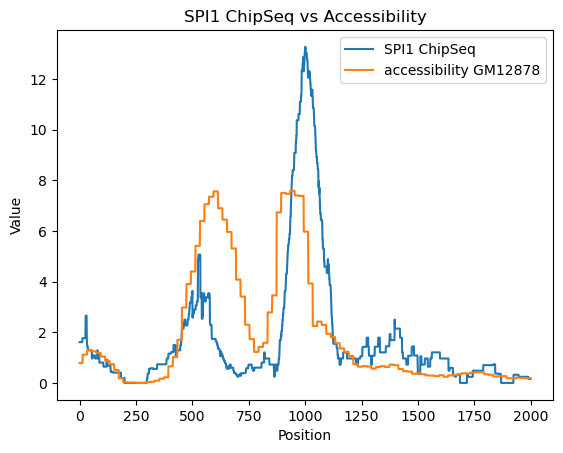

In [71]:
start = 366_132 - 1000
end = 366_132 + 1000

plt.plot(values[start:end], label='SPI1 ChipSeq')
plt.plot(evals.dataset.data['chr19'][0,54083399:54607687][start:end], label='accessibility GM12878')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

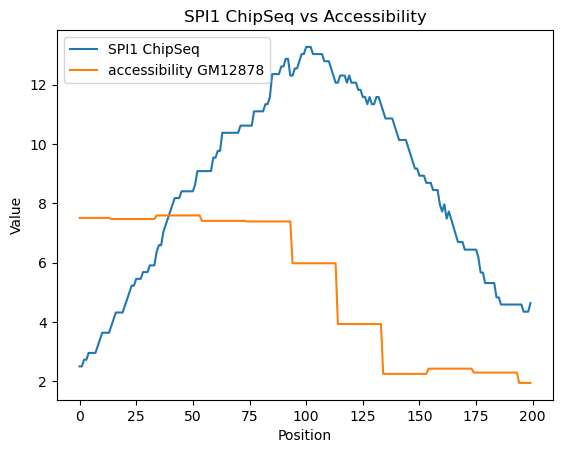

In [72]:
start = 366_132 - 100
end = 366_132 + 100

plt.plot(values[start:end], label='SPI1 ChipSeq')
plt.plot(evals.dataset.data['chr19'][0,54083399:54607687][start:end], label='accessibility GM12878')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [76]:
#let's look at the sequence
# print(evals.dataset.genome['chr19'][366132-50:366132+50])
conversion = {7:'A',8:'C',9:'G',10:'T'}
seq = evals.dataset.genome['chr19'][366132-50:366132+50]
seq = [conversion[x] for x in seq]
print(seq)

['T', 'G', 'A', 'G', 'C', 'C', 'G', 'A', 'G', 'A', 'T', 'C', 'G', 'C', 'G', 'C', 'C', 'A', 'C', 'T', 'G', 'C', 'A', 'C', 'T', 'C', 'C', 'A', 'G', 'C', 'C', 'T', 'G', 'G', 'G', 'C', 'G', 'A', 'C', 'A', 'G', 'A', 'G', 'C', 'A', 'A', 'G', 'A', 'C', 'T', 'C', 'C', 'A', 'T', 'C', 'T', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'G', 'G', 'T', 'G', 'G', 'T', 'C', 'C', 'C', 'A', 'A', 'C', 'T', 'A', 'T', 'G', 'A', 'G', 'T', 'G', 'G', 'G', 'T', 'G', 'G', 'A', 'A', 'G', 'C', 'C', 'T']


In [77]:
#saved spi1 motif here /data1/lesliec/sarthak/caduceus/shap_analysis/modisco/spi1_motif.txt
seq = ''.join(seq)
seq

'TGAGCCGAGATCGCGCCACTGCACTCCAGCCTGGGCGACAGAGCAAGACTCCATCTCAAAAAAAAAAAAGGTGGTCCCAACTATGAGTGGGTGGAAGCCT'

In [78]:
import re
pattern = re.compile(r"AAAAG[ACGT]GGAAGT", re.IGNORECASE)
matches = [match.start() for match in pattern.finditer(seq)]
print("Matches found at positions:", matches)

Matches found at positions: []


In [79]:
seq = 'BBBBBBAAAAGCGGAAGTAAAAAAAAA'
matches = [match.start() for match in pattern.finditer(seq)]
print("Matches found at positions:", matches)

Matches found at positions: [6]


In [81]:
seq = evals.dataset.genome['chr19'][366132-1000:366132+1000]
seq = [conversion[x] for x in seq]
seq = ''.join(seq)
matches = [match.start() for match in pattern.finditer(seq)]
print("Matches found at positions:", matches)

Matches found at positions: []


In [83]:
#hmmm not finding anything... I say we just use fimo. We created the motif matcher, now give it this sequence
seq[:100]

'TCCTGCACGCACCCGCGCTCACCACACACACACGTCGTGAATATAAACATCCATATACTGGTACAGGTGTGAGTGCTTCTCTGGCCCCTGCTCTGCATGC'

In [84]:
#so it's located in /data1/lesliec/sarthak/caduceus/shap_analysis/modisco/sequence_test.fasta

#moved both /data1/lesliec/sarthak/data/joint_playground/fimo_testing/sequence_test.fasta and /data1/lesliec/sarthak/data/joint_playground/fimo_testing/spi1_motif.txt

#oh fimo has an option to search for only a singular motif

#fimo -o /data1/lesliec/sarthak/data/joint_playground/fimo_testing/outputs /data1/lesliec/sarthak/data/joint_playground/fimo_testing/spi1_motif.txt /data1/lesliec/sarthak/data/joint_playground/fimo_testing/sequence_test.fasta

#ok that didn't work, found nothing... hmmmm

#let's update the seq file

seq = evals.dataset.genome['chr19'][366132-10000:366132+10000]
seq = [conversion[x] for x in seq]
seq = ''.join(seq)

with open("/data1/lesliec/sarthak/data/joint_playground/fimo_testing/sequence_test.fasta", "w") as f:
    f.write(">seq1\n")
    f.write(seq + "\n")

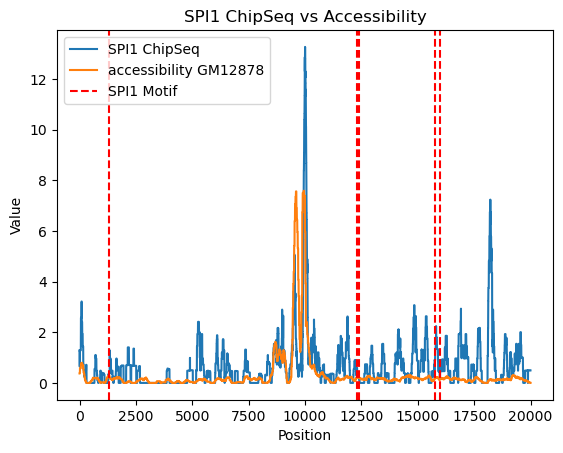

In [ ]:
#fimo -oc /data1/lesliec/sarthak/data/joint_playground/fimo_testing/outputs /data1/lesliec/sarthak/data/joint_playground/fimo_testing/spi1_motif.txt /data1/lesliec/sarthak/data/joint_playground/fimo_testing/sequence_test.fasta

#here's the outputs of the file
'''
motif_id	motif_alt_id	sequence_name	start	stop	strand	score	p-value	q-value	matched_sequence
SPI1_MA0080.4		seq1	15782	15795	+	6.05455	2.86e-05	0.723	AGATGGCGGAAGTG
SPI1_MA0080.4		seq1	12391	12404	+	4.70909	4.16e-05	0.723	TTAAAAGGGAAGTG
SPI1_MA0080.4		seq1	1283	1296	+	3.72727	5.42e-05	0.723	TAATAGAGGATGTT
SPI1_MA0080.4		seq1	15999	16012	-	2.03636	8.39e-05	0.783	AGACAGCGGAAGTG
SPI1_MA0080.4		seq1	12308	12321	+	1.41818	9.79e-05	0.783	TGGAAGAGGAACTG
'''

#let's plot the region then we can put the SPI1 motifs found by fimo

start = 366_132 - 10000
end = 366_132 + 10000

plt.plot(values[start:end], label='SPI1 ChipSeq')
plt.plot(evals.dataset.data['chr19'][0,54083399:54607687][start:end], label='accessibility GM12878')

#now draw lines indicating the spi1 motif
plt.axvline(x=15782, color='red', linestyle='--', label='SPI1 Motif')
plt.axvline(x=12391, color='red', linestyle='--')
plt.axvline(x=1283, color='red', linestyle='--')
plt.axvline(x=15999, color='red', linestyle='--')
plt.axvline(x=12308, color='red', linestyle='--')


plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [89]:
#let's do logoplot of the hit regions
len(seq)

20000

In [ ]:
seq[15782-1:15795] #because they're 1 indexed!

'AGATGGCGGAAGTG'

In [1]:
#let's just run fimo to find all spi1 hits!

#fimo -o /data1/lesliec/sarthak/data/joint_playground/fimo_testing/outputs_full_genome /data1/lesliec/sarthak/data/joint_playground/fimo_testing/spi1_motif.txt /data1/lesliec/sarthak/data/chrombpnet_test/hg38.fa
!nvidia-smi

Wed Apr  2 14:02:33 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:17:00.0 Off |                    0 |
| N/A   29C    P0              43W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# testing on the fimo hits

In [1]:
#let's find some of the bigger hits
#here's an example chr8	74535192	74535205

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
evals = Evals(ckpt_path,device=2)

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [3]:
evals.dataset.sequences.shape

(1937, 4)

In [4]:
#let's append a new thing so we can call it, it will be centered around this new location
evals.dataset.sequences

0          1          2     3
0     chr10   37555537   37686609  test
1     chr14   87048845   87179917  test
2      chrX  136527085  136658157  test
3     chr11   34042349   34173421  test
4     chr19   10352757   10483829  test
...     ...        ...        ...   ...
1932  chr19   33204702   33335774  test
1933  chr14   41861379   41992451  test
1934  chr19   30681544   30812616  test
1935  chr14   61473198   61604270  test
1936   chr2  129664471  129795543  test

[1937 rows x 4 columns]

In [7]:
#let's append the data
import pandas as pd
new_row = pd.Series({0:'chr8', 1:74535192, 2:74535205, 3:0})
evals.dataset.sequences = evals.dataset.sequences.append(new_row, ignore_index=True)
evals.dataset.sequences

AttributeError: 'DataFrame' object has no attribute 'append'

In [8]:
new_row = pd.DataFrame([[ 'chr8', 74535192, 74535205, 0 ]], columns=evals.dataset.sequences.columns)
evals.dataset.sequences = pd.concat([evals.dataset.sequences, new_row], ignore_index=True)
evals.dataset.sequences

0          1          2     3
0     chr10   37555537   37686609  test
1     chr14   87048845   87179917  test
2      chrX  136527085  136658157  test
3     chr11   34042349   34173421  test
4     chr19   10352757   10483829  test
...     ...        ...        ...   ...
1933  chr14   41861379   41992451  test
1934  chr19   30681544   30812616  test
1935  chr14   61473198   61604270  test
1936   chr2  129664471  129795543  test
1937   chr8   74535192   74535205     0

[1938 rows x 4 columns]

In [9]:
evals.dataset.sequences.index[-1] #what we expect!

1937

In [2]:
#I implemented it in my thing, restart and test it
start = 74535192 - 524288//2
end = 74535192 + 524288//2
evals.dataset.expand_seqs('chr8',start,end)

1937

In [7]:
#let's get the sequences to see if it matches what we think
seq = evals.dataset.genome['chr8'][start:end]
seq[524288//2-1:524288//2+13] #this matches fimo!!

array([ 7,  7,  7,  7,  7,  9,  8,  9,  9,  7,  7,  9, 10,  7], dtype=int8)

In [11]:
print(start,end)

74273048 74797336


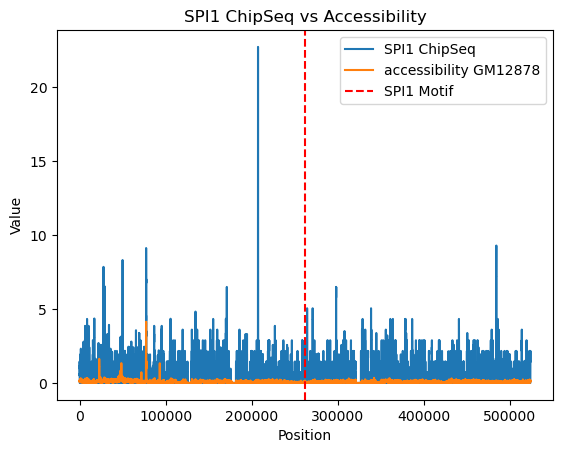

In [10]:
#now let's plot it
import numpy as np
import matplotlib.pyplot as plt
import pyBigWig

bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')

values = np.array(bw.values('chr8', start, end))

plt.plot(values, label='SPI1 ChipSeq')
plt.plot(evals.dataset.data['chr8'][0,start:end], label='accessibility GM12878')

#now draw lines indicating the spi1 motif
plt.axvline(x=524288//2+5, color='red', linestyle='--', label='SPI1 Motif')

plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [12]:
#it's not a great overlap here either lol. Let's see if that big peak is a hit
values.argmax()

207494

In [13]:
#rough location
207494 + start

74480542

In [16]:
#nah that's not even there... wtf?

#let's keep looking through examples until we find an area that's accessibile and it chip seq peak where motif is
import pandas as pd
fimo = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/fimo_testing/outputs_full_genome/fimo.tsv', sep='\t', skipfooter=4, engine='python')
fimo

motif_id  motif_alt_id sequence_name      start       stop strand  \
0      SPI1_MA0080.4           NaN          chr8   74535192   74535205      +   
1      SPI1_MA0080.4           NaN          chr2   81574522   81574535      -   
2      SPI1_MA0080.4           NaN          chr3   88199423   88199436      +   
3      SPI1_MA0080.4           NaN          chr4   92725904   92725917      +   
4      SPI1_MA0080.4           NaN         chr10   99897605   99897618      -   
...              ...           ...           ...        ...        ...    ...   
63083  SPI1_MA0080.4           NaN          chr1  230339678  230339691      +   
63084  SPI1_MA0080.4           NaN          chr2  236452836  236452849      -   
63085  SPI1_MA0080.4           NaN          chr1  238100138  238100151      -   
63086  SPI1_MA0080.4           NaN          chr1  238580407  238580420      +   
63087  SPI1_MA0080.4           NaN          chr2  239923632  239923645      +   

         score       p-value  q-value matched_sequence  
0      24.7273  5.160000e-09    0.101   AAAAAGCGGAAGTA  
1      24.7273  5.160000e-09    0.101   AAAAAGCGGAAGTA  
2      24.7273  5.160000e-09    0.101   AAAAAGCGGAAGTA  
3      24.7273  5.160000e-09    0.101   AAAAAGCGGAAGTA  
4      24.7273  5.160000e-09    0.101   AAAAAGCGGAAGTA  
...        ...           ...      ...              ...  
63083  12.3455  4.010000e-06    0.371   AAAAGGAGGAAGTC  
63084  12.3455  4.010000e-06    0.371   TAAAAAAGGAAGTT  
63085  12.3455  4.010000e-06    0.371   TAAAAAAGGAAGTT  
63086  12.3455  4.010000e-06    0.371   TGAAACAGGAAGTA  
63087  12.3455  4.010000e-06    0.371   GAAAAGAGGAAGAG  

[63088 rows x 10 columns]

In [19]:
from tqdm import tqdm
for i in tqdm(range(fimo.shape[0])):
    start = fimo.iloc[i]['start'] - 524288//2
    end = start + 524288
    chrom = fimo.iloc[i]['sequence_name']
    
    data = evals.dataset.data[chrom][0, start:end]
    
    if data[524288//2-1:524288//2+13].mean() > 1:
        # print(chrom, start, end)
        # print(data[524288//2-1:524288//2+13])
        #let's plot it
        # plt.plot(data.cpu().numpy(), label='accessibility GM12878')
        
        # bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')
    
        values = np.array(bw.values(chrom, start, end))
        if values[524288//2-1:524288//2+13].mean() > 1:
            print(chrom, start, end)
            print(evals.data.genome[chrom][524288//2-1:524288//2+13])
            plt.plot(values, label='SPI1 ChipSeq')
            plt.plot(data.cpu().numpy(), label='accessibility GM12878')
            
            #now draw lines indicating the spi1 motif
            plt.axvline(x=524288//2+5, color='red', linestyle='--', label='SPI1 Motif')

            plt.xlabel('Position')
            plt.ylabel('Value')
            plt.title('SPI1 ChipSeq vs Accessibility')
            plt.legend()
            plt.show()
    

  0%|          | 16/63088 [00:19<21:20:19,  1.22s/it]


KeyboardInterrupt: 

In [20]:
#too slow
loaded_data = {}
for key in evals.dataset.data.keys():
    loaded_data[key] = evals.dataset.data[key][:]

  0%|          | 0/63088 [00:00<?, ?it/s]

chr16 67219170 67743458
[ 9  9  8  7  9  8  8 10 10  9  9 10  9 10]


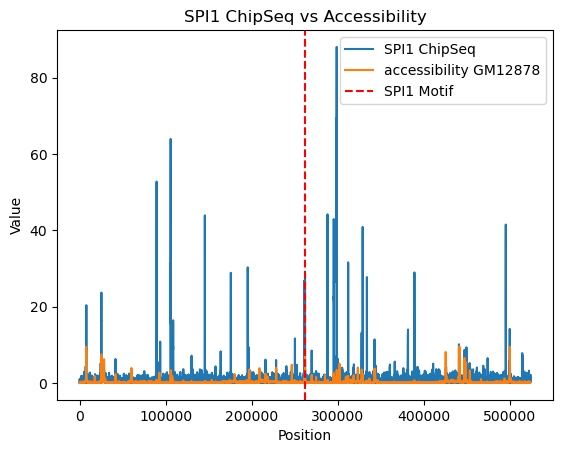

  0%|          | 311/63088 [00:00<01:55, 541.56it/s]


In [27]:
from tqdm import tqdm
for i in tqdm(range(fimo.shape[0])):
    start = fimo.iloc[i]['start'] - 524288//2
    end = start + 524288
    chrom = fimo.iloc[i]['sequence_name']
    
    if chrom not in loaded_data:
        continue

    data = loaded_data[chrom][0, start:end]
    
    if data[524288//2-1:524288//2+13].mean() > 5:
        # print(chrom, start, end)
        # print(data[524288//2-1:524288//2+13])
        #let's plot it
        # plt.plot(data.cpu().numpy(), label='accessibility GM12878')
        
        # bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')
    
        values = np.array(bw.values(chrom, start, end))
        if values[524288//2-1:524288//2+13].mean() > 1:
            print(chrom, start, end)
            print(evals.dataset.genome[chrom][524288//2-1:524288//2+13])
            plt.plot(values, label='SPI1 ChipSeq')
            plt.plot(data, label='accessibility GM12878')
            
            #now draw lines indicating the spi1 motif
            plt.axvline(x=524288//2+5, color='red', linestyle='--', label='SPI1 Motif')

            plt.xlabel('Position')
            plt.ylabel('Value')
            plt.title('SPI1 ChipSeq vs Accessibility')
            plt.legend()
            plt.show()
            break

  0%|          | 0/63088 [00:00<?, ?it/s]

chr16 67219170 67743458
[ 7  7  7  7  7  9  7  9  9  7  7  9 10 10]


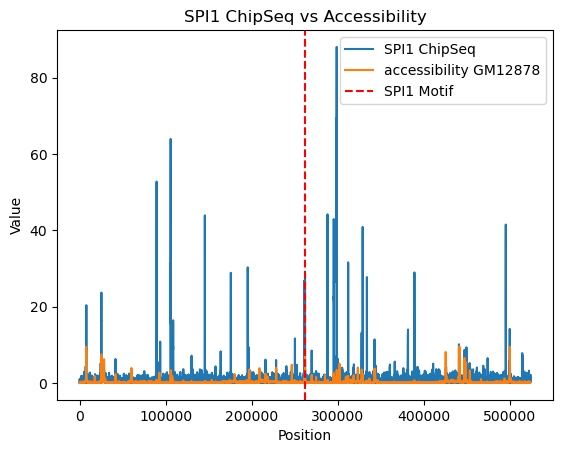

  0%|          | 311/63088 [00:00<02:04, 504.88it/s]


In [37]:
#wait it's minus strand, so let's reverse this sequence and see. Let's just skip this one and look for a plus strand, minus strand too annoying to think about, as what I'm indexing is assuming minus strand
from tqdm import tqdm
for i in tqdm(range(fimo.shape[0])):
    if fimo.iloc[i]['strand'] == '-':
        continue
    start = fimo.iloc[i]['start'] - 524288//2
    end = start + 524288
    chrom = fimo.iloc[i]['sequence_name']
    
    if chrom not in loaded_data:
        continue

    data = loaded_data[chrom][0, start:end]
    
    if data[524288//2-1:524288//2+13].mean() > 5:
        # print(chrom, start, end)
        # print(data[524288//2-1:524288//2+13])
        #let's plot it
        # plt.plot(data.cpu().numpy(), label='accessibility GM12878')
        
        # bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')
    
        values = np.array(bw.values(chrom, start, end))
        if values[524288//2-1:524288//2+13].mean() > 1:
            print(chrom, start, end)
            print(evals.dataset.genome[chrom][start+524288//2-1:start+524288//2+13])
            plt.plot(values, label='SPI1 ChipSeq')
            plt.plot(data, label='accessibility GM12878')
            
            #now draw lines indicating the spi1 motif
            plt.axvline(x=524288//2+5, color='red', linestyle='--', label='SPI1 Motif')

            plt.xlabel('Position')
            plt.ylabel('Value')
            plt.title('SPI1 ChipSeq vs Accessibility')
            plt.legend()
            plt.show()
            break

In [32]:
fimo.iloc[i]

motif_id             SPI1_MA0080.4
motif_alt_id                   NaN
sequence_name                chr16
start                     67481314
stop                      67481327
strand                           +
score                      22.4364
p-value                        0.0
q-value                      0.101
matched_sequence    AAAAAGAGGAAGTT
Name: 311, dtype: object

In [34]:
start+524288//2 #it litterally does match!

67481314

In [40]:
#it looks good, let's verify this is in a CRE
cre = pd.read_csv('/data1/deyk/ENCODE/cCREv4/Human_CellType/ENCFF428XFI_ENCFF280PUF_ENCFF469WVA_ENCFF644EEX.bed.gz', sep='\t', compression='gzip', header=None)
cre.head()

0      1      2             3   4  5      6      7            8   \
0  chr1  10033  10250  EH38E2776516   0  .  10033  10250  225,225,225   
1  chr1  10385  10713  EH38E2776517   0  .  10385  10713  225,225,225   
2  chr1  16097  16381  EH38E3951272   0  .  16097  16381  225,225,225   
3  chr1  17343  17642  EH38E3951273   0  .  17343  17642  225,225,225   
4  chr1  29320  29517  EH38E3951274   0  .  29320  29517  225,225,225   

          9                             10  
0  Low-DNase  All-data/Full-classification  
1  Low-DNase  All-data/Full-classification  
2  Low-DNase  All-data/Full-classification  
3  Low-DNase  All-data/Full-classification  
4  Low-DNase  All-data/Full-classification

In [41]:
#now we want to find ones that are in chromosome 16 and start before 67481314 and end after 67481314
cre = cre[(cre[0] == 'chr16') & (cre[1] < 67481314) & (cre[2] > 67481314)]

In [42]:
cre

0         1         2             3   4  5         6         7   \
810799  chr16  67481083  67481431  EH38E1822992   0  .  67481083  67481431   

             8    9                             10  
810799  255,0,0  PLS  All-data/Full-classification

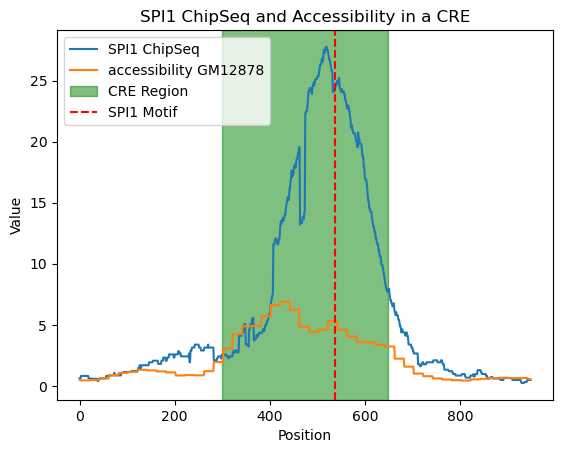

In [54]:
ts = 67481083-300
te = 67481431+300

length = te - ts

plt.plot(bw.values('chr16', ts, te), label='SPI1 ChipSeq')
plt.plot(evals.dataset.data['chr16'][0, ts:te], label='accessibility GM12878')

#add in the cre
plt.axvspan(300, length-300, color='green', alpha=0.5, label='CRE Region')
plt.axvline(x=67481314+5-ts, color='red', linestyle='--', label='SPI1 Motif')


plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq and Accessibility in a CRE')
plt.legend()

In [57]:
#add this sequence to the dataset 67219170 67743458
print(start,end, end-start)

evals.dataset.expand_seqs('chr16',start,end)

67219170 67743458 524288


1938

In [58]:
#so we know that ts and te are in our thing, let's find where
si = 67481083-start
se = 67481431-start
print(si,se)

261913 262261


In [61]:
len(evals.dataset)

1939

In [59]:
out = evals.dataset[1938]
for i in range(4):
    print(out[i].shape)

UnboundLocalError: cannot access local variable 'seq' where it is not associated with a value

In [63]:
index = 1938
chrom, start, end, split = evals.dataset.sequences.iloc[index]
print(chrom, start, end, split)

chr16 67219170 67743458 test


In [65]:
evals.dataset.length - (end-start)

0

In [ ]:
#predict with just masked accessibility
out = evals.mask()

# restart one more time and plot

In [1]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
evals = Evals(ckpt_path,device=2)

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [2]:
import pandas as pd
fimo = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/fimo_testing/outputs_full_genome/fimo.tsv', sep='\t', skipfooter=4, engine='python')

loaded_data = {}
for key in evals.dataset.data.keys():
    loaded_data[key] = evals.dataset.data[key][:]

In [3]:
import pyBigWig
bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')

  0%|          | 0/63088 [00:00<?, ?it/s]

chr16 67219170 67743458
[ 7  7  7  7  7  9  7  9  9  7  7  9 10 10]


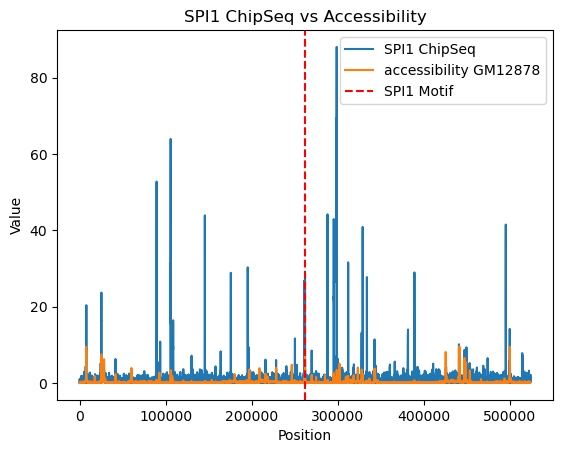

  0%|          | 311/63088 [00:00<02:55, 356.77it/s]


In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm
for i in tqdm(range(fimo.shape[0])):
    if fimo.iloc[i]['strand'] == '-':
        continue
    start = fimo.iloc[i]['start'] - 524288//2
    end = start + 524288
    chrom = fimo.iloc[i]['sequence_name']
    
    if chrom not in loaded_data:
        continue

    data = loaded_data[chrom][0, start:end]
    
    if data[524288//2-1:524288//2+13].mean() > 5:
        # print(chrom, start, end)
        # print(data[524288//2-1:524288//2+13])
        #let's plot it
        # plt.plot(data.cpu().numpy(), label='accessibility GM12878')
        
        # bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')
    
        values = np.array(bw.values(chrom, start, end))
        if values[524288//2-1:524288//2+13].mean() > 1:
            print(chrom, start, end)
            print(evals.dataset.genome[chrom][start+524288//2-1:start+524288//2+13])
            plt.plot(values, label='SPI1 ChipSeq')
            plt.plot(data, label='accessibility GM12878')
            
            #now draw lines indicating the spi1 motif
            plt.axvline(x=524288//2+5, color='red', linestyle='--', label='SPI1 Motif')

            plt.xlabel('Position')
            plt.ylabel('Value')
            plt.title('SPI1 ChipSeq vs Accessibility')
            plt.legend()
            plt.show()
            break

In [11]:
start,end

(67219170, 67743458)

In [5]:

evals.dataset.expand_seqs('chr16',start,end)

1937

In [14]:
out = evals.dataset[1937]
for i in range(2):
    print(out[i][0].shape, out[i][1].shape)

torch.Size([6, 524288]) torch.Size([2, 524288])
torch.Size([524288, 6]) torch.Size([524288, 2])


In [6]:
#so this works, let's plot and see if we can get the shape of our peak as before
si = 67481083-start
se = 67481431-start
print(si,se)

261913 262261


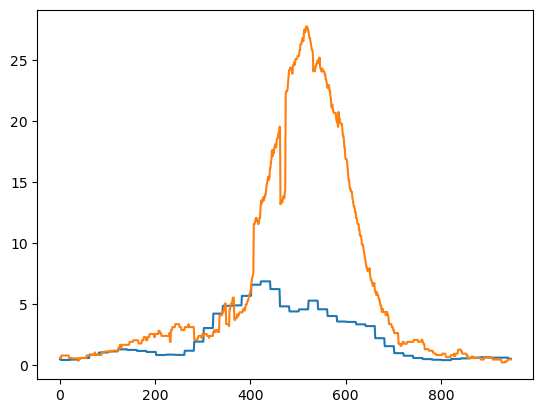

In [18]:
plt.plot(out[1][1][si-300:se+300,0])
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location

In [19]:
#now we have to get the output, let's mask out this region
out = evals.mask(si,se, 1937, mask_accessibility=True)
for i in range(len(out)):
    print(out[i].shape)

torch.Size([1, 524288, 5])
torch.Size([1, 524288, 1])
torch.Size([524288, 6])
torch.Size([524288, 2])
torch.Size([1, 6, 524288])
torch.Size([1, 2, 524288])


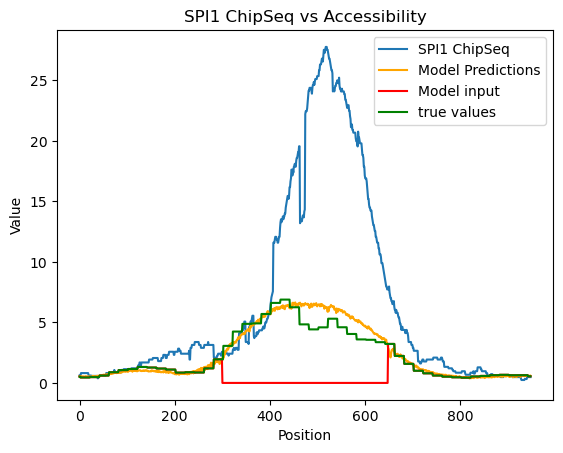

In [24]:
#let's do the plot

plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [9]:
out = evals.mask(si-200,se+200, 1937, mask_accessibility=True)

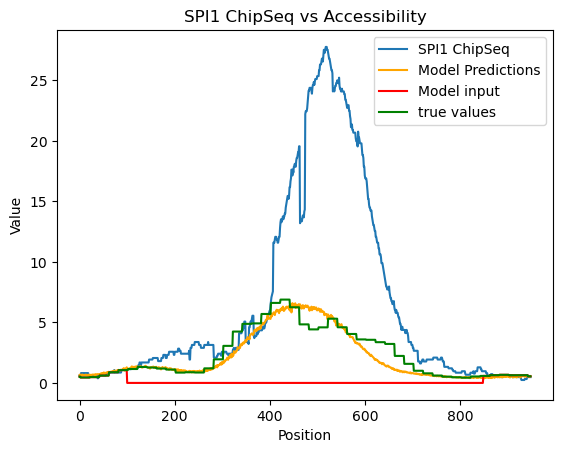

In [26]:
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [7]:
#let's find where the mask starts!
mi = 67481314 - start - 1
me = 67481327 - start
print(mi,me)
print(si,se)

262143 262157
261913 262261


In [10]:
out[-2][0,:, mi:me] #AAAAAGAGGAAGTT vs AAAAAGAGGAAGTT

tensor([[1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:2')

In [45]:
out = evals.mask(mi-100,me+100, 1937, start_acc=si-200,stop_acc=se+200, mask_accessibility=True, mask_sequence=True)

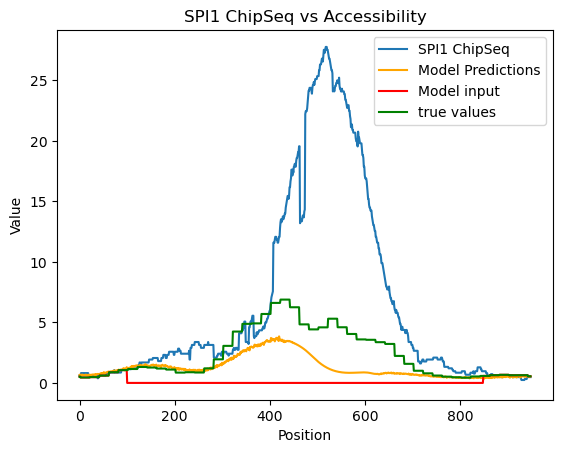

In [46]:
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [47]:
out = evals.mask(mi-10,me+10, 1937, start_acc=si-200,stop_acc=se+200, mask_accessibility=True, mask_sequence=True)

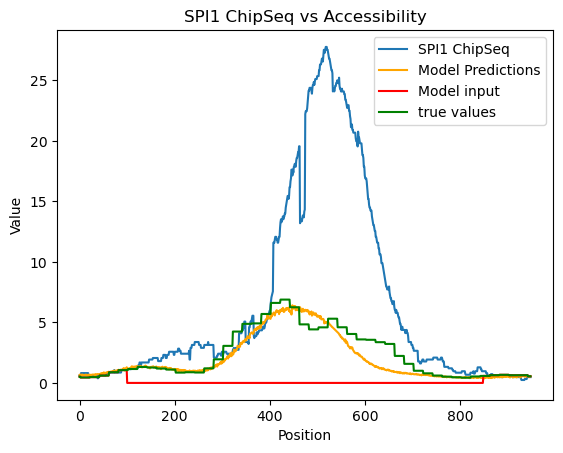

In [48]:
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [49]:
out = evals.mask(mi-10,me+10, 1937, start_acc=si-200,stop_acc=se+200, mask_accessibility=True, randomize_sequence=True)

RuntimeError: The expanded size of the tensor (34) must match the existing size (4) at non-singleton dimension 1.  Target sizes: [4, 34].  Tensor sizes: [34, 4]

In [50]:
random_indices = torch.randint(0, 4, size=(32,))
torch.nn.functional.one_hot(random_indices, num_classes=4).shape

torch.Size([32, 4])

In [51]:
out = evals(0)
for i in range(len(out)):
    print(out[i].shape)

torch.Size([1, 524288, 5])
torch.Size([1, 524288, 1])
torch.Size([524288, 6])
torch.Size([524288, 2])


In [13]:
out = evals.mask(mi-10,me+10, 1937, start_acc=si-200,stop_acc=se+200, mask_accessibility=True, randomize_sequence=True, mask_sequence=True)

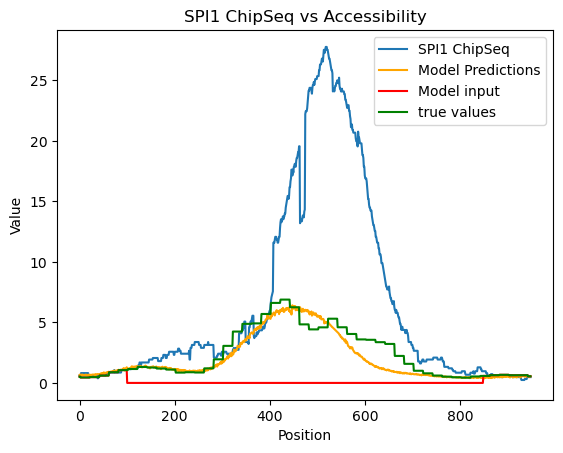

In [14]:
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [17]:
out = evals.mask(mi-10,me+10, 1937, start_acc=si,stop_acc=se, mask_accessibility=True, randomize_sequence=True)

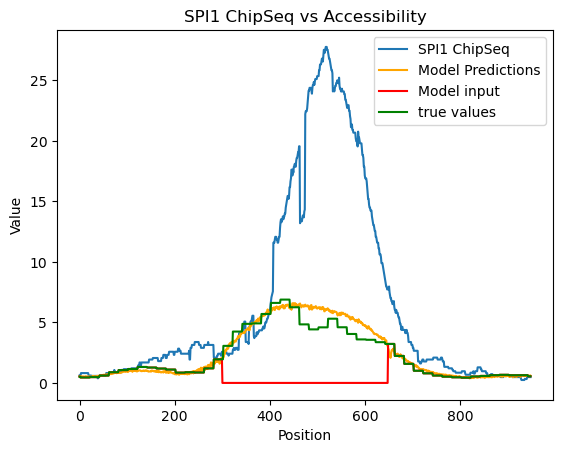

In [18]:
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

# final task, see what the model is predicting for sequence

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


  0%|          | 0/63088 [00:00<?, ?it/s]

chr16 67219170 67743458
[ 7  7  7  7  7  9  7  9  9  7  7  9 10 10]


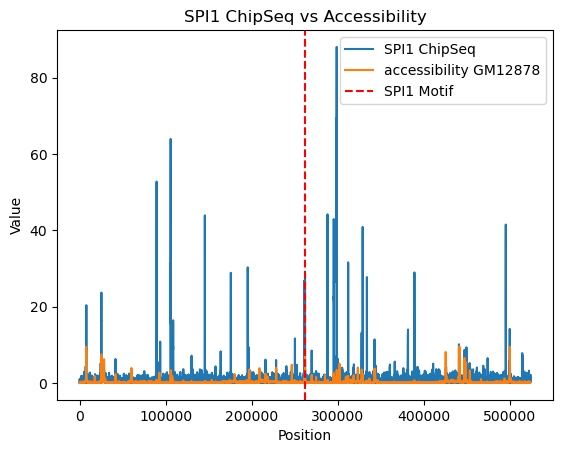

  0%|          | 311/63088 [00:00<02:57, 352.70it/s]


In [7]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
evals = Evals(ckpt_path,device=2)
import pandas as pd
fimo = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/fimo_testing/outputs_full_genome/fimo.tsv', sep='\t', skipfooter=4, engine='python')

loaded_data = {}
for key in evals.dataset.data.keys():
    loaded_data[key] = evals.dataset.data[key][:]
import pyBigWig
bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')
import matplotlib.pyplot as plt
from tqdm import tqdm
for i in tqdm(range(fimo.shape[0])):
    if fimo.iloc[i]['strand'] == '-':
        continue
    start = fimo.iloc[i]['start'] - 524288//2
    end = start + 524288
    chrom = fimo.iloc[i]['sequence_name']
    
    if chrom not in loaded_data:
        continue

    data = loaded_data[chrom][0, start:end]
    
    if data[524288//2-1:524288//2+13].mean() > 5:
        # print(chrom, start, end)
        # print(data[524288//2-1:524288//2+13])
        #let's plot it
        # plt.plot(data.cpu().numpy(), label='accessibility GM12878')
        
        # bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')
    
        values = np.array(bw.values(chrom, start, end))
        if values[524288//2-1:524288//2+13].mean() > 1:
            print(chrom, start, end)
            print(evals.dataset.genome[chrom][start+524288//2-1:start+524288//2+13])
            plt.plot(values, label='SPI1 ChipSeq')
            plt.plot(data, label='accessibility GM12878')
            
            #now draw lines indicating the spi1 motif
            plt.axvline(x=524288//2+5, color='red', linestyle='--', label='SPI1 Motif')

            plt.xlabel('Position')
            plt.ylabel('Value')
            plt.title('SPI1 ChipSeq vs Accessibility')
            plt.legend()
            plt.show()
            break

In [8]:
evals.dataset.expand_seqs('chr16',start,end)

1937

In [9]:
si = 67481083-start
se = 67481431-start
mi = 67481314 - start - 1
me = 67481327 - start

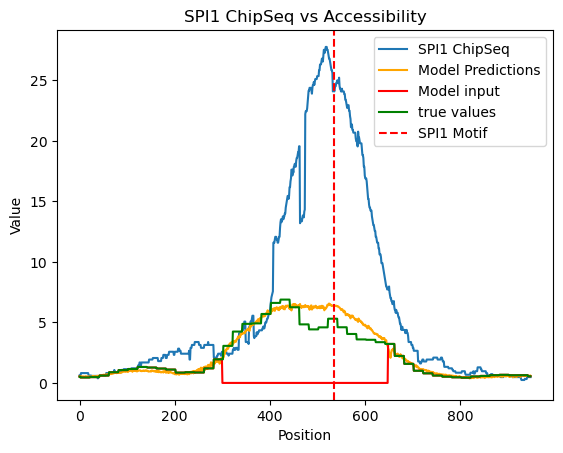

In [22]:
out = evals.mask(mi-10,me+10, 1937, start_acc=si,stop_acc=se, mask_accessibility=True, mask_sequence=True)
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.axvline(x=mi+5-si+300, color='red', linestyle='--', label='SPI1 Motif')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [ ]:
#let's see what's input for the sequence, for the masked region

#perfect it's masked!

out[-2][0,:, mi:me] #AAAAAGAGGAAGTT vs AAAAAGAGGAAGTT

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       device='cuda:2')

In [26]:
out[0].shape

torch.Size([1, 524288, 5])

In [ ]:
out[0][0].softmax(-1).sum(1) #each row sums to 1!!

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:2')

In [27]:
out[2].shape

torch.Size([524288, 6])

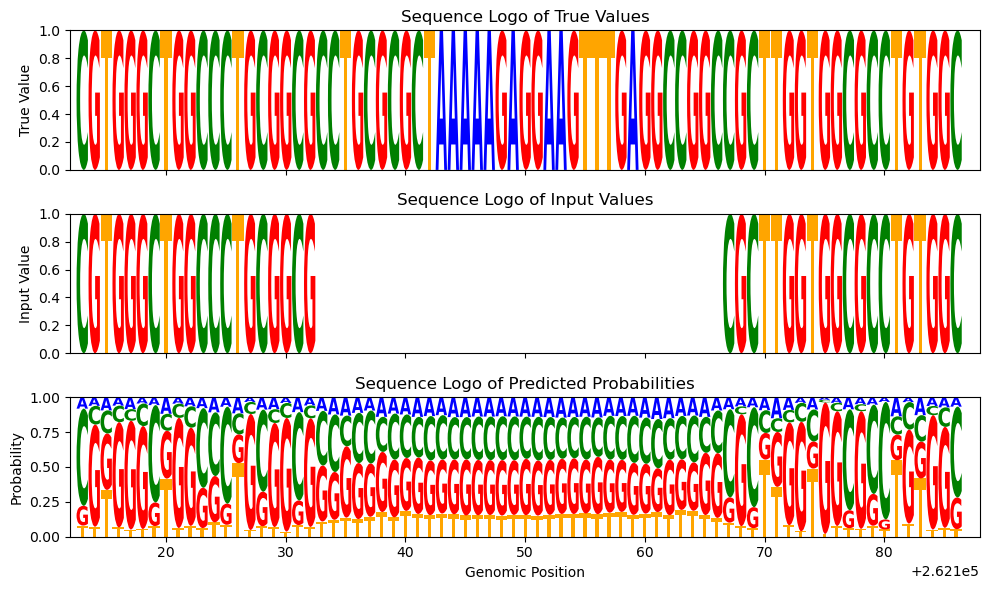

In [35]:
#so now let's create a logo plot

import logomaker

true_values = out[2][:,:5].cpu().numpy()
input_values = out[-2][0,:5].cpu().transpose(1,0).numpy()
softmaxed = out[0][0].softmax(dim=-1).cpu().numpy()

# Define nucleotides and corresponding colors.
nucleotides = ['A', 'C', 'G', 'T', 'N']
color_dict = {'A': 'blue', 'C': 'green', 'G': 'red', 'T': 'orange', 'N': 'purple'}

# Choose a window of positions to visualize (e.g., positions 10000 to 10050)
# start, end = 10000, 10050
# subset = softmaxed_data[start:end]
# true_values = true_values[start:end]

s_index = mi - 30
e_index = me + 30

positions = np.arange(s_index, e_index)

# Create DataFrames for true_values, input_values, and softmaxed
df_true = pd.DataFrame(true_values[s_index:e_index], columns=nucleotides, index=positions)
df_input = pd.DataFrame(input_values[s_index:e_index], columns=nucleotides, index=positions)
df_softmax = pd.DataFrame(softmaxed[s_index:e_index], columns=nucleotides, index=positions)

# Create three subplots (stacked vertically)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 6))

# Top plot: True values
logo1 = logomaker.Logo(df_true, ax=ax1, color_scheme=color_dict, stack_order='fixed')
ax1.set_ylabel("True Value")
ax1.set_title("Sequence Logo of True Values")

# Middle plot: Input values
logo2 = logomaker.Logo(df_input, ax=ax2, color_scheme=color_dict, stack_order='fixed')
ax2.set_ylabel("Input Value")
ax2.set_title("Sequence Logo of Input Values")

# Bottom plot: Predicted probabilities (softmaxed)
logo3 = logomaker.Logo(df_softmax, ax=ax3, color_scheme=color_dict, stack_order='fixed')
ax3.set_xlabel("Genomic Position")
ax3.set_ylabel("Probability")
ax3.set_title("Sequence Logo of Predicted Probabilities")

# Set x-axis limits
plt.xlim(s_index - 1, e_index + 1)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

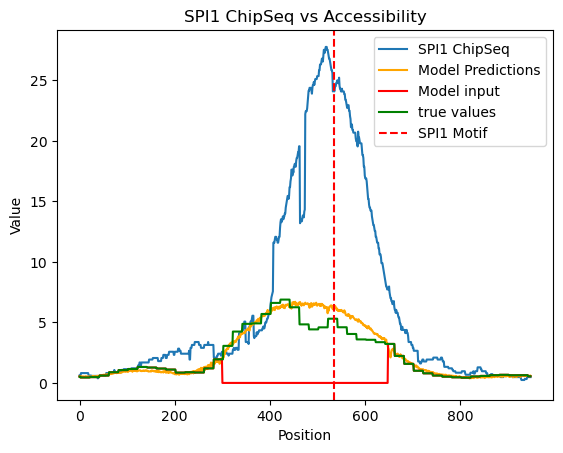

In [36]:
#uhhhh, maybe too much masked out?

out = evals.mask(mi+4,me-4, 1937, start_acc=si,stop_acc=se, mask_accessibility=True, mask_sequence=True)
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.axvline(x=mi+5-si+300, color='red', linestyle='--', label='SPI1 Motif')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

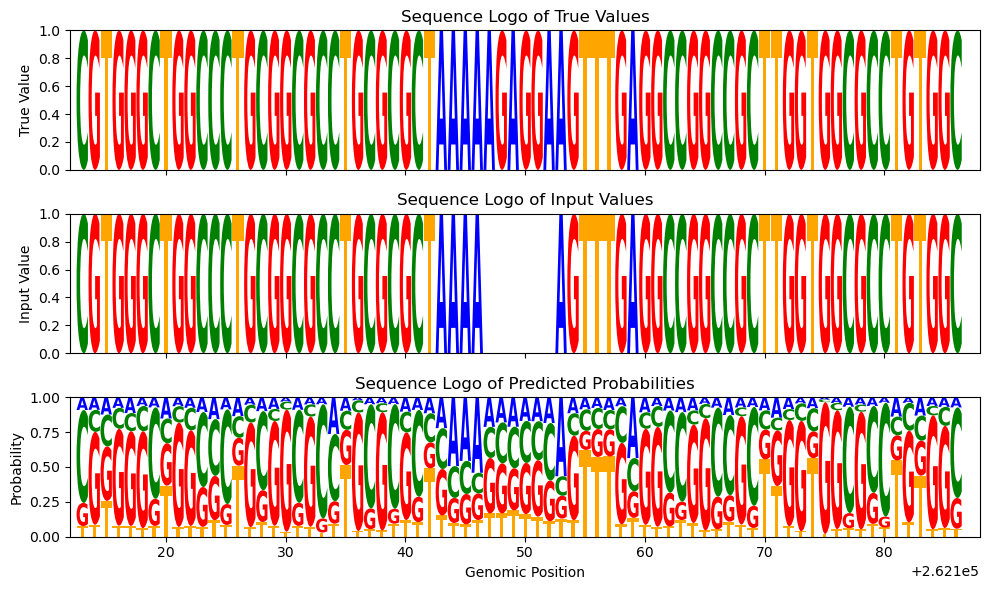

In [37]:
true_values = out[2][:,:5].cpu().numpy()
input_values = out[-2][0,:5].cpu().transpose(1,0).numpy()
softmaxed = out[0][0].softmax(dim=-1).cpu().numpy()

# Define nucleotides and corresponding colors.
nucleotides = ['A', 'C', 'G', 'T', 'N']
color_dict = {'A': 'blue', 'C': 'green', 'G': 'red', 'T': 'orange', 'N': 'purple'}

# Choose a window of positions to visualize (e.g., positions 10000 to 10050)
# start, end = 10000, 10050
# subset = softmaxed_data[start:end]
# true_values = true_values[start:end]

s_index = mi - 30
e_index = me + 30

positions = np.arange(s_index, e_index)

# Create DataFrames for true_values, input_values, and softmaxed
df_true = pd.DataFrame(true_values[s_index:e_index], columns=nucleotides, index=positions)
df_input = pd.DataFrame(input_values[s_index:e_index], columns=nucleotides, index=positions)
df_softmax = pd.DataFrame(softmaxed[s_index:e_index], columns=nucleotides, index=positions)

# Create three subplots (stacked vertically)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 6))

# Top plot: True values
logo1 = logomaker.Logo(df_true, ax=ax1, color_scheme=color_dict, stack_order='fixed')
ax1.set_ylabel("True Value")
ax1.set_title("Sequence Logo of True Values")

# Middle plot: Input values
logo2 = logomaker.Logo(df_input, ax=ax2, color_scheme=color_dict, stack_order='fixed')
ax2.set_ylabel("Input Value")
ax2.set_title("Sequence Logo of Input Values")

# Bottom plot: Predicted probabilities (softmaxed)
logo3 = logomaker.Logo(df_softmax, ax=ax3, color_scheme=color_dict, stack_order='fixed')
ax3.set_xlabel("Genomic Position")
ax3.set_ylabel("Probability")
ax3.set_title("Sequence Logo of Predicted Probabilities")

# Set x-axis limits
plt.xlim(s_index - 1, e_index + 1)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

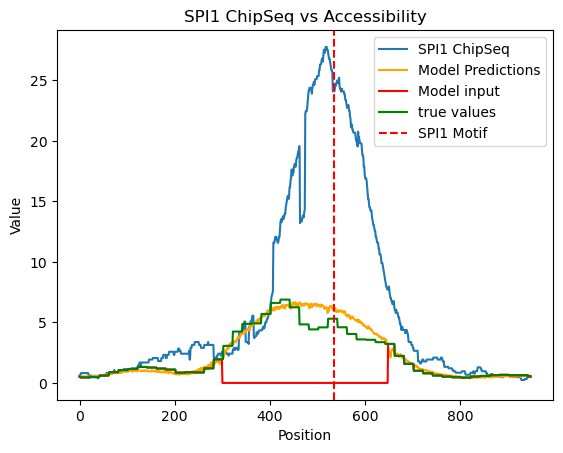

In [38]:
out = evals.mask(mi+5,me-5, 1937, start_acc=si,stop_acc=se, mask_accessibility=True, mask_sequence=True)
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.axvline(x=mi+5-si+300, color='red', linestyle='--', label='SPI1 Motif')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

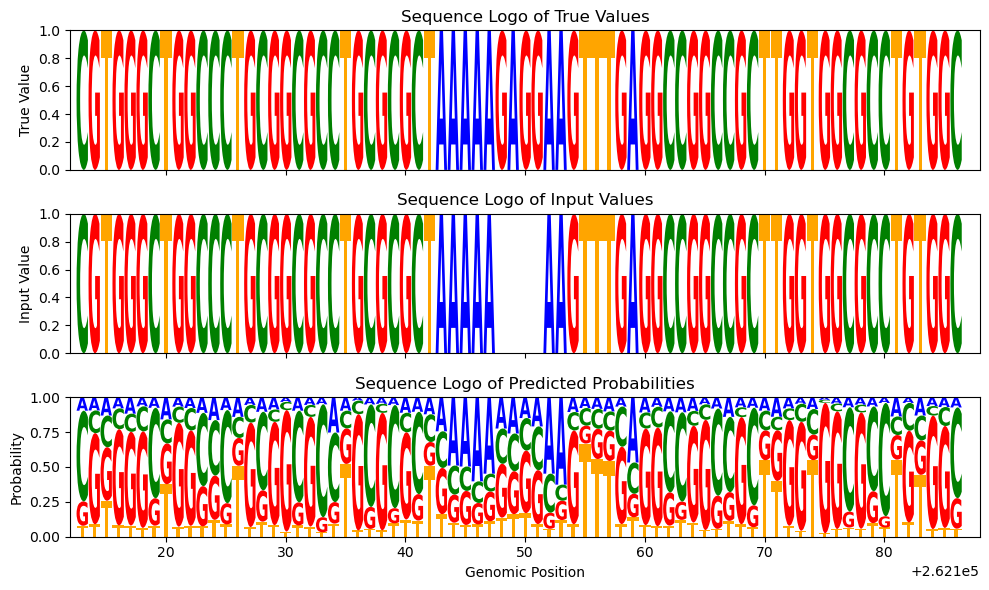

In [39]:
true_values = out[2][:,:5].cpu().numpy()
input_values = out[-2][0,:5].cpu().transpose(1,0).numpy()
softmaxed = out[0][0].softmax(dim=-1).cpu().numpy()

# Define nucleotides and corresponding colors.
nucleotides = ['A', 'C', 'G', 'T', 'N']
color_dict = {'A': 'blue', 'C': 'green', 'G': 'red', 'T': 'orange', 'N': 'purple'}

# Choose a window of positions to visualize (e.g., positions 10000 to 10050)
# start, end = 10000, 10050
# subset = softmaxed_data[start:end]
# true_values = true_values[start:end]

s_index = mi - 30
e_index = me + 30

positions = np.arange(s_index, e_index)

# Create DataFrames for true_values, input_values, and softmaxed
df_true = pd.DataFrame(true_values[s_index:e_index], columns=nucleotides, index=positions)
df_input = pd.DataFrame(input_values[s_index:e_index], columns=nucleotides, index=positions)
df_softmax = pd.DataFrame(softmaxed[s_index:e_index], columns=nucleotides, index=positions)

# Create three subplots (stacked vertically)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 6))

# Top plot: True values
logo1 = logomaker.Logo(df_true, ax=ax1, color_scheme=color_dict, stack_order='fixed')
ax1.set_ylabel("True Value")
ax1.set_title("Sequence Logo of True Values")

# Middle plot: Input values
logo2 = logomaker.Logo(df_input, ax=ax2, color_scheme=color_dict, stack_order='fixed')
ax2.set_ylabel("Input Value")
ax2.set_title("Sequence Logo of Input Values")

# Bottom plot: Predicted probabilities (softmaxed)
logo3 = logomaker.Logo(df_softmax, ax=ax3, color_scheme=color_dict, stack_order='fixed')
ax3.set_xlabel("Genomic Position")
ax3.set_ylabel("Probability")
ax3.set_title("Sequence Logo of Predicted Probabilities")

# Set x-axis limits
plt.xlim(s_index - 1, e_index + 1)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

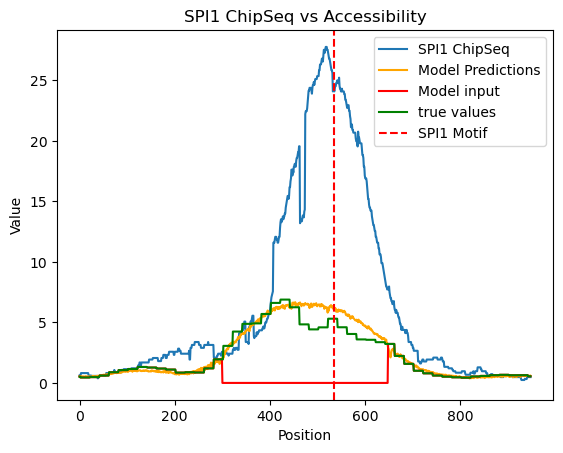

In [40]:
out = evals.mask(mi+6,me-6, 1937, start_acc=si,stop_acc=se, mask_accessibility=True, mask_sequence=True)
plt.plot(bw.values('chr16', start, end)[si-300:se+300], label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(out[1][0, si-300:se+300, 0].cpu().numpy(), label='Model Predictions', color='orange')
plt.plot(out[-1][0, 0, si-300:se+300].cpu().numpy(), label='Model input', color='red')
plt.plot(out[-3][si-300:se+300,0], label='true values', color='green')
plt.axvline(x=mi+5-si+300, color='red', linestyle='--', label='SPI1 Motif')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

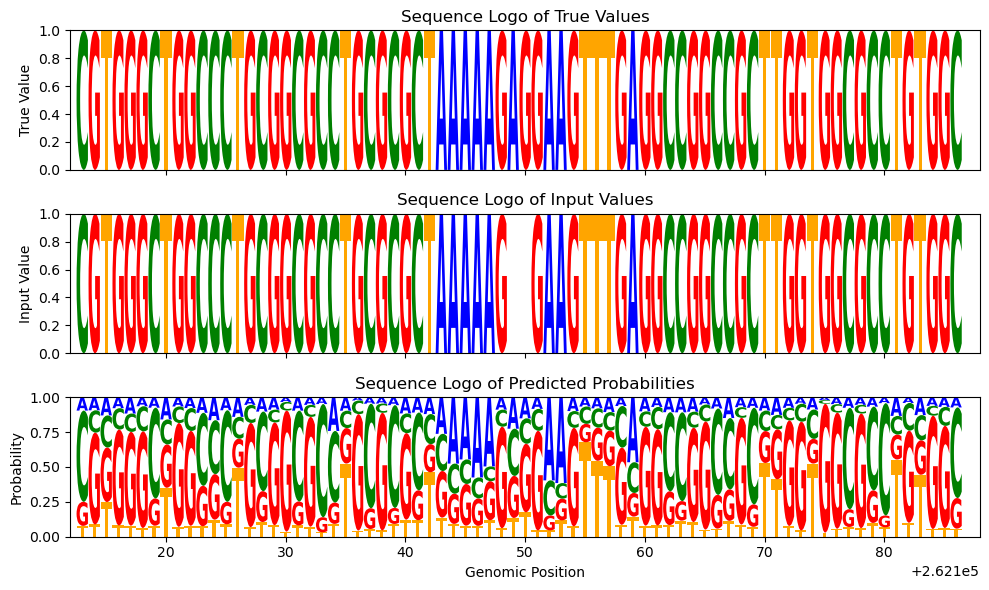

In [41]:
true_values = out[2][:,:5].cpu().numpy()
input_values = out[-2][0,:5].cpu().transpose(1,0).numpy()
softmaxed = out[0][0].softmax(dim=-1).cpu().numpy()

# Define nucleotides and corresponding colors.
nucleotides = ['A', 'C', 'G', 'T', 'N']
color_dict = {'A': 'blue', 'C': 'green', 'G': 'red', 'T': 'orange', 'N': 'purple'}

# Choose a window of positions to visualize (e.g., positions 10000 to 10050)
# start, end = 10000, 10050
# subset = softmaxed_data[start:end]
# true_values = true_values[start:end]

s_index = mi - 30
e_index = me + 30

positions = np.arange(s_index, e_index)

# Create DataFrames for true_values, input_values, and softmaxed
df_true = pd.DataFrame(true_values[s_index:e_index], columns=nucleotides, index=positions)
df_input = pd.DataFrame(input_values[s_index:e_index], columns=nucleotides, index=positions)
df_softmax = pd.DataFrame(softmaxed[s_index:e_index], columns=nucleotides, index=positions)

# Create three subplots (stacked vertically)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(10, 6))

# Top plot: True values
logo1 = logomaker.Logo(df_true, ax=ax1, color_scheme=color_dict, stack_order='fixed')
ax1.set_ylabel("True Value")
ax1.set_title("Sequence Logo of True Values")

# Middle plot: Input values
logo2 = logomaker.Logo(df_input, ax=ax2, color_scheme=color_dict, stack_order='fixed')
ax2.set_ylabel("Input Value")
ax2.set_title("Sequence Logo of Input Values")

# Bottom plot: Predicted probabilities (softmaxed)
logo3 = logomaker.Logo(df_softmax, ax=ax3, color_scheme=color_dict, stack_order='fixed')
ax3.set_xlabel("Genomic Position")
ax3.set_ylabel("Probability")
ax3.set_title("Sequence Logo of Predicted Probabilities")

# Set x-axis limits
plt.xlim(s_index - 1, e_index + 1)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# final thing, get enformer prediction with random nucleotides in that region

JointMaskingDecoder: d_model=256, d_output1=5, d_output2=1
JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


  0%|          | 0/63088 [00:00<?, ?it/s]

chr16 67219170 67743458
[ 7  7  7  7  7  9  7  9  9  7  7  9 10 10]


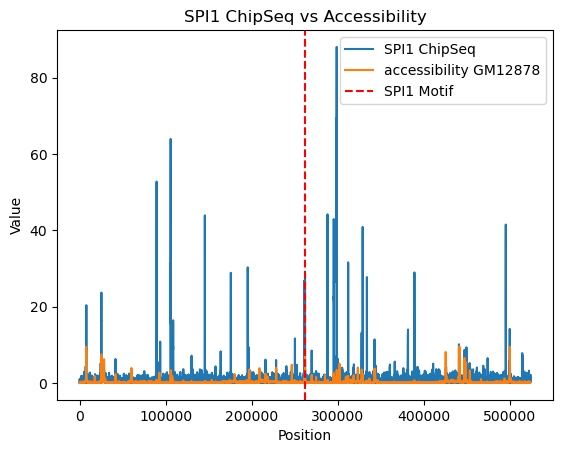

  0%|          | 311/63088 [00:00<02:11, 479.12it/s]


In [1]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-03-27/16-43-18-348625/checkpoints/08-val_loss=0.00000.ckpt'

import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
from evals.evals_utils_joint import Evals
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
evals = Evals(ckpt_path,device=1)
import pandas as pd
fimo = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/fimo_testing/outputs_full_genome/fimo.tsv', sep='\t', skipfooter=4, engine='python')

loaded_data = {}
for key in evals.dataset.data.keys():
    loaded_data[key] = evals.dataset.data[key][:]
import pyBigWig
bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')
import matplotlib.pyplot as plt
from tqdm import tqdm
for i in tqdm(range(fimo.shape[0])):
    if fimo.iloc[i]['strand'] == '-':
        continue
    start = fimo.iloc[i]['start'] - 524288//2
    end = start + 524288
    chrom = fimo.iloc[i]['sequence_name']
    
    if chrom not in loaded_data:
        continue

    data = loaded_data[chrom][0, start:end]
    
    if data[524288//2-1:524288//2+13].mean() > 5:
        # print(chrom, start, end)
        # print(data[524288//2-1:524288//2+13])
        #let's plot it
        # plt.plot(data.cpu().numpy(), label='accessibility GM12878')
        
        # bw = pyBigWig.open('/data1/lesliec/sarthak/data/DK_zarr/bw_files/ENCFF998DST.bigWig')
    
        values = np.array(bw.values(chrom, start, end))
        if values[524288//2-1:524288//2+13].mean() > 1:
            print(chrom, start, end)
            print(evals.dataset.genome[chrom][start+524288//2-1:start+524288//2+13])
            plt.plot(values, label='SPI1 ChipSeq')
            plt.plot(data, label='accessibility GM12878')
            
            #now draw lines indicating the spi1 motif
            plt.axvline(x=524288//2+5, color='red', linestyle='--', label='SPI1 Motif')

            plt.xlabel('Position')
            plt.ylabel('Value')
            plt.title('SPI1 ChipSeq vs Accessibility')
            plt.legend()
            plt.show()
            break

In [3]:
midpoint = (start+end)//2
midpoint

67481314

In [4]:
chrom

'chr16'

In [2]:
#now I am putting that into enformer
si = 67481083-start
se = 67481431-start
mi = 67481314 - start - 1
me = 67481327 - start
print(si,se,mi,me)

261913 262261 262143 262157


In [9]:
#so for enformer which is centered around the midpoint, we can do this
length=196608
pos = midpoint
newstart = pos - length//2
newend = pos + length//2
print(newstart,newend)
# print(newstart-start,newend-start)
seq = torch.zeros((1,4,newend-newstart))
print(seq.shape)

67383010 67579618
torch.Size([1, 4, 196608])


In [11]:
#now we need to find mi and si relative to it
mi = 67481314 - newstart -1
me = 67481327 - newstart
print(mi,me)

98303 98317


In [4]:
evals.dataset.expand_seqs('chr16',start,end)

1937

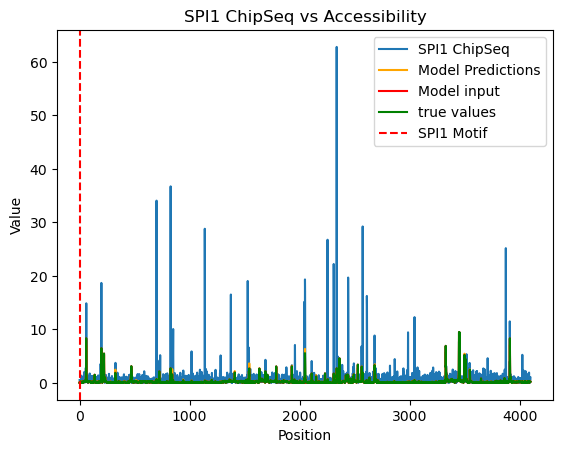

In [9]:
out = evals.mask(mi+5,me-5, 1937, start_acc=si,stop_acc=se, mask_accessibility=True, mask_sequence=True)

#now we ned to bin to 128 bp resolution
preds = out[1][0, :, 0].cpu().numpy()
preds = np.mean(preds.reshape(-1, 128), axis=1)
# print(preds.shape) #4096
inputs = out[-1][0, 0, :].cpu().numpy()
inputs = np.mean(inputs.reshape(-1, 128), axis=1)

true_vals = out[-3][:,0].cpu().numpy()
true_vals = np.mean(true_vals.reshape(-1, 128), axis=1)

chip_seq = np.array(bw.values('chr16', start, end))
chip_seq = np.mean(chip_seq.reshape(-1, 128), axis=1)

plt.plot(chip_seq, label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(preds, label='Model Predictions', color='orange')
plt.plot(inputs, label='Model input', color='red')
plt.plot(true_vals, label='true values', color='green')
plt.axvline(x=(mi+5-si+300)//128, color='red', linestyle='--', label='SPI1 Motif')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

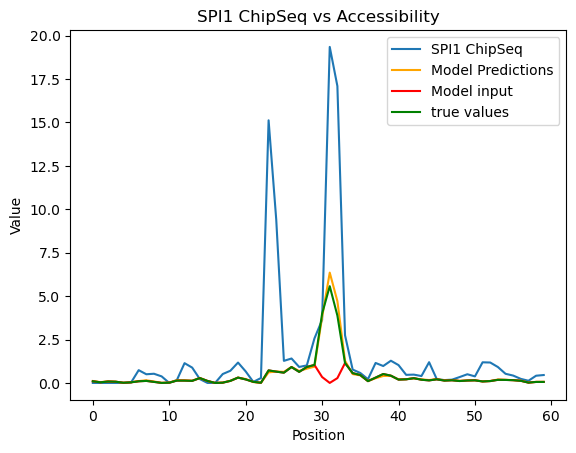

In [20]:
#have to zoom in still, too many peaks! 
out = evals.mask(mi+5,me-5, 1937, start_acc=si,stop_acc=se, mask_accessibility=True, mask_sequence=True)

#now we ned to bin to 128 bp resolution
preds = out[1][0, :, 0].cpu().numpy()
preds = np.mean(preds.reshape(-1, 128), axis=1)[si//128-30:si//128+30]
# print(preds.shape) #4096
inputs = out[-1][0, 0, :].cpu().numpy()
inputs = np.mean(inputs.reshape(-1, 128), axis=1)[si//128-30:si//128+30]

true_vals = out[-3][:,0].cpu().numpy()
true_vals = np.mean(true_vals.reshape(-1, 128), axis=1)[si//128-30:si//128+30]

chip_seq = np.array(bw.values('chr16', start, end))
chip_seq = np.mean(chip_seq.reshape(-1, 128), axis=1)[si//128-30:si//128+30]

plt.plot(chip_seq, label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(preds, label='Model Predictions', color='orange')
plt.plot(inputs, label='Model input', color='red')
plt.plot(true_vals, label='true values', color='green')
# plt.axvline(x=31, color='red', linestyle='--', label='SPI1 Motif')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

In [18]:
mi//128

2047

In [22]:
#now add in enformer predictions in here!
enformer_preds = np.load('/data1/lesliec/sarthak/deepmind-research/enformer/random_runs/chr16_67481314.npy')
print(enformer_preds.shape)
#and restrict to our two things
enformer_base = enformer_preds[0, :, 12]
enformer_rand = enformer_preds[1, :, 12]
print(enformer_base.shape, enformer_rand.shape)

(2, 896, 5313)
(896,) (896,)


In [24]:
#already binned, let's find the coords
corrds = np.arange(start, end, 128)
print(corrds.shape)

(4096,)


In [25]:
pos = 67481314
length = 196608
enfstart = pos - length//2
enfend = pos + length//2
np.abs(corrds-enfstart).min()

0

In [26]:
#perfect match, so it goes to that bin
np.abs(corrds-enfstart).argmin()

1280

In [27]:
#goes from bin 1280 to 1280+896, let's check
np.abs(corrds-enfend).argmin()

2816

In [ ]:
2816-1280 #oh this is input values... then that's subset to these coords

1536

In [32]:
length = 114688
enfstart = pos - length//2
enfend = pos + length//2
np.abs(corrds-enfstart).min()

0

In [33]:
print(np.abs(corrds-enfstart).argmin())
print(np.abs(corrds-enfend).argmin())

1600
2496


In [36]:
2496-1600 #there we go, that's what we expect!!

896

In [ ]:
#now for this hard task
si//128 #oh but we start at 1600, so it's just 2046-1600 and that plus 60!

2046

In [45]:
2046-1600

446

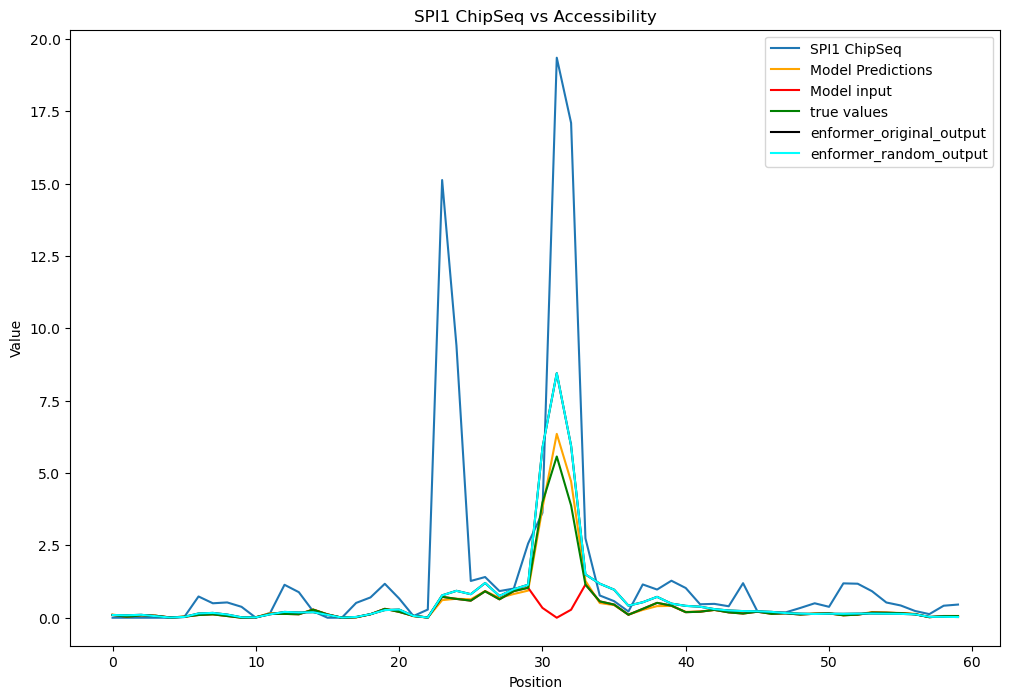

In [46]:
out = evals.mask(mi+5,me-5, 1937, start_acc=si,stop_acc=se, mask_accessibility=True, mask_sequence=True)

plt.subplots(figsize=(12,8))

#now we ned to bin to 128 bp resolution
preds = out[1][0, :, 0].cpu().numpy()
preds = np.mean(preds.reshape(-1, 128), axis=1)[si//128-30:si//128+30]
# print(preds.shape) #4096
inputs = out[-1][0, 0, :].cpu().numpy()
inputs = np.mean(inputs.reshape(-1, 128), axis=1)[si//128-30:si//128+30]

true_vals = out[-3][:,0].cpu().numpy()
true_vals = np.mean(true_vals.reshape(-1, 128), axis=1)[si//128-30:si//128+30]

chip_seq = np.array(bw.values('chr16', start, end))
chip_seq = np.mean(chip_seq.reshape(-1, 128), axis=1)[si//128-30:si//128+30]

enf_preds = enformer_base[446-30:446+30]
enf_rands = enformer_rand[446-30:446+30]

plt.plot(chip_seq, label='SPI1 ChipSeq') #clearly identical, shows we are at the right location
plt.plot(preds, label='Model Predictions', color='orange')
plt.plot(inputs, label='Model input', color='red')
plt.plot(true_vals, label='true values', color='green')
plt.plot(enf_preds, label='enformer_original_output', color='black')
plt.plot(enf_rands, label='enformer_random_output', color='cyan')
# plt.axvline(x=31, color='red', linestyle='--', label='SPI1 Motif')
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('SPI1 ChipSeq vs Accessibility')
plt.legend()

Text(0, 0.5, 'difference between masking motif and leaving it')

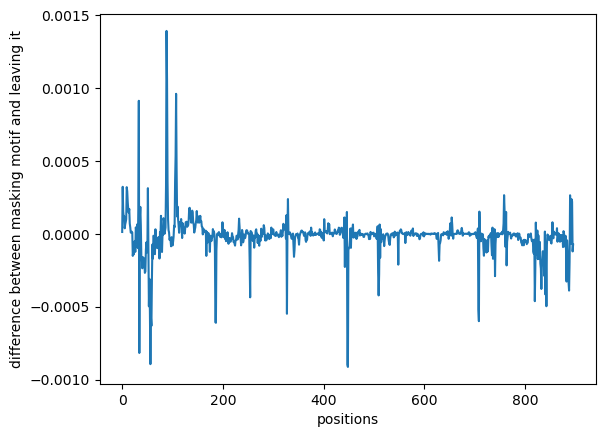

In [47]:
#definitely aligned correctly
plt.plot(enformer_base - enformer_rand) #it's noise, so this is not a motif at all!! 
plt.xlabel('positions')
plt.ylabel('difference between masking motif and leaving it')